# Artificial Neural Network and Deep Learning - Challenge 1

## Hyperparameters

In [282]:
############################################################

SEED = 100
USE_SEED = True

# Training
EPOCHS = 60                        # Maximum epochs (increase to improve performance)
PATIENCE = 500                       # Early stopping patience (increase to improve performance)
VERBOSE = 1                         # Print printing frequency
VALIDATION_SPLIT = 0.2              # Validation split ratio

SELECTED_JOINTS = []


############################################################
# General Paremeters
############################################################

GRADIENT_CLIP_NORM = 0.1

# Loss Function
CROSS_ENTROPY_WEIGHTING = True      # Enable or disable class weighting
WEIGHT_CE_INTENSITY = 1.0           # Intensity of class weighting (higher values increase the effect)
LABEL_SMOOTHING_EPSILON = 0.1       # Label smoothing epsilon (0.0 to disable)

# Optimisation
LEARNING_RATE = 0.001               # Learning rate
BATCH_SIZE = 32                     # Batch size
WINDOW_SIZE = 20                    # Input window size
STRIDE = 10                         # Input stride

# Regularisation
NOISE_STD_DEV = 0.1                 # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.4                 # Dropout probability
L1_LAMBDA = 0.0                     # L1 penalty
L2_LAMBDA = 0.01                    # L2 penalty

WINDOW_INDEX_EMBEDDING_DIM = 8    # Embedding size for the window index

############################################################
# MODEL ARCHITECTURE
############################################################

# CONFIGURATION 
HIDDEN_LAYERS = 3                   # Hidden layers
HIDDEN_SIZE = 32                     # Neurons per layer
RNN_TYPE = 'LSTM'                   # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = False                # Bidirectional RNN
PAIN_EMBEDDING_DIM = 2              # Dimension of pain embedding
STATIC_EMBEDDING_DIM = 4   


############################################################
# TRAINING MODE AND OPTIONS
############################################################

# Select only one of the following training modes
NORMAL_TRAINING = True
CROSS_VALIDATION_TRAINING = True
GRID_SEARCH = False
BAYESIAN_SEARCH = True
FULL_DATASET_TRAINING = True
ENSEMBLE_TRAINING = False            


# --- CROSS-VALIDATION CONFIGURATION ---
K = 5                               # Number of splits for K-Fold CV
VERBOSE_CV_RUN = 1                 # Set to 1 to see epoch-by-epoch in CV


# --- FULL DATASET TRAINING CONFIGURATION ---
OPTIMAL_EPOCHS =  40                # Optimal epochs determined from CV


############################################################
# NOTE; DOESNT WORK  Bayesian Search Hyperparameter Ranges 

BS_N_TRIALS = 2

# === Float Ranges [min, max] ===
# Note: BS_L2_LAMBDA min is set to 1e-5 as log scale cannot start from 0.
BS_LEARNING_RATE = [1e-3, 1e-4]
BS_L2_LAMBDA = [1e-2, 1e-3, 1e-4]

BS_WEIGHT_CE_INTENSITY = [1.0, 2.0]
BS_DROPOUT_RATE = [0.0, 0.3, 0.5]
BS_LABEL_SMOOTHING = [0.0, 0.1]
BS_NOISE_STD_DEV = [0.0, 0.1]

# === Categorical Lists ===
BS_HIDDEN_SIZE = [32, 64, 128]
BS_HIDDEN_LAYERS = [1, 2, 3]
BS_PAIN_EMBEDDING_DIM = [1, 2]
BS_WINDOW_EMBEDDING_DIM = [4, 8]

############################################################


## Libraries and dataset import

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
import sys
from itertools import product
from itertools import chain
import optuna

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import torch.nn as nn
from datetime import datetime 
import hashlib
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats as sp_stats
from torchsummary import summary 
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from torch.utils.tensorboard import SummaryWriter
import math

import torch.nn.functional as F
from IPython.display import display, clear_output


if USE_SEED:
    print(f"Using fixed random seed: {SEED}")
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
else:
    print("Running with random seed.")


if torch.cuda.is_available():
    device = torch.device("cuda")
    if USE_SEED:
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

df_train = pd.read_csv('pirate_pain_train.csv')
df_labels = pd.read_csv('pirate_pain_train_labels.csv')


rnn_map = {
    'RNN': nn.RNN,
    'LSTM': nn.LSTM,
    'GRU': nn.GRU
}

Using fixed random seed: 100
PyTorch version: 2.9.0+cu128
Device: cuda


## Data Analysis

### Preprocessing

#### PainDataset Class

In [259]:
class PainDataset(Dataset):

    def __init__(self, X_joint, X_pain, X_window_idx, X_static, y_target, window_sample_indices,
                 is_train=False, noise_level=0.00):
        
        self.X_joint = torch.tensor(X_joint, dtype=torch.float32)
        self.X_pain = torch.tensor(X_pain, dtype=torch.long) 
        self.X_window_idx = torch.tensor(X_window_idx, dtype=torch.long)
        self.X_static = torch.tensor(X_static, dtype=torch.long) 
        self.y_target = torch.tensor(y_target, dtype=torch.long)
        self.window_sample_indices = window_sample_indices        
        self.is_train = is_train
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y_target)
    
    def __getitem__(self, idx):
        x_joint_sample = self.X_joint[idx].clone()
        x_pain_sample = self.X_pain[idx].clone()
        x_window_idx_sample = self.X_window_idx[idx]
        x_static_sample = self.X_static[idx] 
        y_target_sample = self.y_target[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn_like(x_joint_sample) * self.noise_level
            x_joint_sample = x_joint_sample + noise
        
        return (x_joint_sample, x_pain_sample, x_window_idx_sample, x_static_sample), y_target_sample

#### Feature Columns Definition

In [260]:
def define_feature_columns(df_train, selected_indices=SELECTED_JOINTS):
    
    original_joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
    original_joint_cols = original_joint_cols[:-1] 
    
    pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
    static_cols = [c for c in df_train.columns if c.startswith('n_')]

    if not selected_indices: 
        print("No specific joint indices provided. Defaulting to use ALL available joints.\n")
        selected_joint_cols = original_joint_cols
    else:
        print(f"Selecting a subset of joints based on provided indices: {selected_indices}\n")
        try:
            selected_joint_cols = [original_joint_cols[i] for i in selected_indices]
        except IndexError:
            print("ERROR: One of the selected_joint_indices is out of range.")
            print(f"You have {len(original_joint_cols)} joints (indices 0 to {len(original_joint_cols)-1}).")
            raise
    
    joint_input_size = len(selected_joint_cols)
    pain_input_size = len(pain_cols)

    label_map = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
    inverse_label_map = {v: k for k, v in label_map.items()}

    if selected_indices:
        print(f"Joint input size: {joint_input_size} (Selected Joints: {selected_joint_cols})")
    else:
        print(f"Joint input size: {joint_input_size} (Using ALL Joints)")
        
    print(f"Pain surveys input size: {pain_input_size} (Surveys)")
    print(f"Static features: : {static_cols}\n")
    
    return (original_joint_cols, pain_cols, static_cols, selected_joint_cols, label_map, inverse_label_map)



#### Data Splitting

In [261]:
def split_data(df_train, df_labels, test_split_size, random_state):

    print(f"Splitting data by sample_index (Test split size: {test_split_size})...")
    unique_sample_ids = df_labels['sample_index'].unique()
    
    training_sample_ids, validation_sample_ids = train_test_split(
        unique_sample_ids,
        test_size=test_split_size,
        random_state=random_state,
        stratify=df_labels['label']
    )
    
    df_training_split = df_train[df_train['sample_index'].isin(training_sample_ids)]
    df_labels_trainining_split = df_labels[df_labels['sample_index'].isin(training_sample_ids)]
    df_val_split = df_train[df_train['sample_index'].isin(validation_sample_ids)]
    df_labels_val_split = df_labels[df_labels['sample_index'].isin(validation_sample_ids)]
    
    return (
        df_training_split, df_labels_trainining_split, 
        df_val_split, df_labels_val_split, 
        training_sample_ids, validation_sample_ids
    )

#### Normalization

In [262]:
def get_normalization_stats(df_training, joint_cols):

    # --- 1. Joint Features ---
    joint_data = df_training[joint_cols].values
    joint_data_min_vec = np.min(joint_data, axis=0)
    joint_data_max_vec = np.max(joint_data, axis=0)
    print(f"Global joints min/max length: {joint_data_min_vec.shape}")


    stats = {
        'joint_data_min_vec': joint_data_min_vec,
        'joint_data_max_vec': joint_data_max_vec,
    }
    return stats

#### Window Building

In [263]:
def build_fixed_sequences(df_features, df_labels, 
                          joint_cols, pain_cols, static_cols, label_map,
                          static_mappings,
                          joint_data_min_vec, joint_data_max_vec,
                          window, stride):


    dataset_joint_windows = []
    dataset_pain_windows = [] 
    dataset_static_features = [] 
    labels_windows = []
    sample_indices = []
    dataset_window_indices = [] 
    
    # --- Pre-calculate normalization ranges for JOINT data ---
    joint_range_vec = joint_data_max_vec - joint_data_min_vec
    joint_range_vec[joint_range_vec == 0] = 1
    joint_min_tensor = torch.FloatTensor(joint_data_min_vec)
    joint_range_tensor = torch.FloatTensor(joint_range_vec)


    for sample_id in df_features['sample_index'].unique():
        temp_df = df_features[df_features['sample_index'] == sample_id].sort_values('time')
        
        temp_features_joint = temp_df[joint_cols].values
        temp_features_pain = temp_df[pain_cols].values
        

        static_row_raw = temp_df[static_cols].iloc[0] 
        
        encoded_static_features = []
        for col_name in static_cols:
            string_val = static_row_raw[col_name]
            try:
                int_val = static_mappings[col_name][string_val]
                encoded_static_features.append(int_val)
            except KeyError:
                print(f"!!! WARNING: Unknown static value '{string_val}' in column '{col_name}' for sample {sample_id}.")
                print("This might happen if a value appears in test but not train. Defaulting to 0.")
                encoded_static_features.append(0) # Default to 0


        label_str = df_labels[df_labels['sample_index'] == sample_id]['label'].values[0]
        label_numeric = label_map[label_str]

        joint_data_tensor = torch.FloatTensor(temp_features_joint)
        normalized_joint_tensor = 2 * ((joint_data_tensor - joint_min_tensor) / joint_range_tensor) - 1
        temp_normalized_joint_vec = normalized_joint_tensor.numpy()
        
        
        idx = 0
        window_idx_counter = 0
        while idx + window <= len(temp_normalized_joint_vec):
            dataset_joint_windows.append(temp_normalized_joint_vec[idx:idx + window])
            dataset_pain_windows.append(temp_features_pain[idx:idx + window] )
            labels_windows.append(label_numeric)
            sample_indices.append(sample_id)
            dataset_window_indices.append(window_idx_counter)
            
            dataset_static_features.append(encoded_static_features) 
            
            idx += stride
            window_idx_counter += 1

    dataset_joint_windows = np.array(dataset_joint_windows, dtype=np.float32)
    dataset_pain_windows = np.array(dataset_pain_windows, dtype=np.int64) 
    dataset_static_features = np.array(dataset_static_features, dtype=np.int64) 
    labels_windows = np.array(labels_windows, dtype=np.int64)

    return (dataset_joint_windows, dataset_pain_windows, dataset_window_indices, dataset_static_features), labels_windows, np.array(sample_indices)

#### Create Dataloader

In [264]:
def create_dataloaders(df_training_split, df_labels_training_split,
                       df_val_split, df_labels_val_split,
                       joint_cols, pain_cols, static_cols_raw, label_map,
                       static_mappings,
                       stats_dict, 
                       window_size, stride, batch_size, noise_std_dev,
                       ):
    
    # Build Training sequences
    (X_train_joint, X_train_pain, X_train_window_idx, X_train_static), y_train, train_window_sids = build_fixed_sequences(
        df_training_split, df_labels_training_split,
        joint_cols, pain_cols, static_cols_raw, label_map,
        static_mappings,
        joint_data_min_vec=stats_dict['joint_data_min_vec'],
        joint_data_max_vec=stats_dict['joint_data_max_vec'],
        window=window_size,
        stride=stride
    )
    
    # Build Validation sequences
    (X_val_joint, X_val_pain, X_val_window_idx, X_val_static), y_val, val_window_sids = build_fixed_sequences(
        df_val_split, df_labels_val_split,
        joint_cols, pain_cols, static_cols_raw, label_map,
        static_mappings,
        joint_data_min_vec=stats_dict['joint_data_min_vec'],
        joint_data_max_vec=stats_dict['joint_data_max_vec'],
        window=window_size,
        stride=stride
    )
    
    train_window_counts = pd.Series(train_window_sids).value_counts().mean()
    val_window_counts = pd.Series(val_window_sids).value_counts().mean()

    print(f"\nTotal windows created (Train): {len(y_train)}")
    print(f"Total number of indices per window (Train): {train_window_counts}" )

    print(f"Total windows created (Val):   {len(y_val)}")
    print(f"Total number of indices per window (Val): {val_window_counts}")
    print(f"Shape of X_train_joint: {X_train_joint.shape}") 
    print(f"Shape of X_train_pain: {X_train_pain.shape}") 

    num_window_idx = int(train_window_counts)


    # Create Datasets (Pass the new summary data)
    train_dataset = PainDataset(
        X_train_joint, X_train_pain, X_train_window_idx, X_train_static, y_train, train_window_sids,
        is_train=True,
        noise_level=noise_std_dev
    )
    val_dataset = PainDataset(
        X_val_joint, X_val_pain, X_val_window_idx, X_val_static, y_val, val_window_sids,
        is_train=False,
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("\n--- Data Pipeline Complete ---")
    print(f"Train loader has {len(train_loader)} batches.")
    print(f"Validation loader has {len(val_loader)} batches.")


    
    return train_loader, val_loader, num_window_idx


#### Main Preprocessing

In [265]:
print(f"#################################################################################################")
# --- 1. Define Columns ---
(   original_joint_cols, pain_cols, static_cols_raw, 
    joint_cols, label_map, inverse_label_map
) = define_feature_columns(df_train)

# --- 2. Split Data ---
(   df_train_split, df_labels_train_split, 
    df_val_split, df_labels_val_split,
    train_sids, val_sids
) = split_data(df_train, df_labels, VALIDATION_SPLIT, SEED)


static_vocab_sizes = []
static_mappings = {}
for col in static_cols_raw:
    unique_vals = df_train[col].unique()
    col_map = {val: i for i, val in enumerate(unique_vals)}
    vocab_size_for_col = len(col_map)
    
    static_vocab_sizes.append(vocab_size_for_col)
    static_mappings[col] = col_map
    
    print(f"  - Column '{col}': {vocab_size_for_col} unique values. Mapping created.")
    print(f"    Mapping: {col_map}") # Uncomment to verify

# --- 3. Get Normalization Stats ---
stats_dict = get_normalization_stats(
    df_train, 
    joint_cols
)

JOINT_DATA_MIN_VEC = stats_dict['joint_data_min_vec']
JOINT_DATA_MAX_VEC = stats_dict['joint_data_max_vec']


# --- 4. Create DataLoaders ---
train_loader, val_loader, num_window_idx = create_dataloaders(
    df_train_split, df_labels_train_split,
    df_val_split, df_labels_val_split,
    joint_cols, pain_cols, static_cols_raw, label_map,
    static_mappings,
    stats_dict, 
    WINDOW_SIZE, STRIDE, BATCH_SIZE, NOISE_STD_DEV,
)

# --- 6. Final Check ---
(x_joint_batch, x_pain_batch, window_idx_batch, x_static_batch), y_batch = next(iter(train_loader))
print(f"Joint batch shape:   {x_joint_batch.shape} (dtype: {x_joint_batch.dtype})") 
print(f"Pain batch shape:  {x_pain_batch.shape} (dtype: {x_pain_batch.dtype})")
print(f"Window index batch shape:  {window_idx_batch.shape} (dtype: {x_pain_batch.dtype})")
print(f"Static batch shape:  {x_static_batch.shape} (dtype: {x_static_batch.dtype})")
print(f"Label batch shape: {y_batch.shape} (dtype: {y_batch.dtype})")
print(f"#################################################################################################")

#################################################################################################
No specific joint indices provided. Defaulting to use ALL available joints.

Joint input size: 30 (Using ALL Joints)
Pain surveys input size: 4 (Surveys)
Static features: : ['n_legs', 'n_hands', 'n_eyes']

Splitting data by sample_index (Test split size: 0.2)...
  - Column 'n_legs': 2 unique values. Mapping created.
    Mapping: {'two': 0, 'one+peg_leg': 1}
  - Column 'n_hands': 2 unique values. Mapping created.
    Mapping: {'two': 0, 'one+hook_hand': 1}
  - Column 'n_eyes': 2 unique values. Mapping created.
    Mapping: {'two': 0, 'one+eye_patch': 1}
Global joints min/max length: (30,)

Total windows created (Train): 7920
Total number of indices per window (Train): 15.0
Total windows created (Val):   1995
Total number of indices per window (Val): 15.0
Shape of X_train_joint: (7920, 20, 30)
Shape of X_train_pain: (7920, 20, 4)

--- Data Pipeline Complete ---
Train loader has 248 batches.


--- Plotting a single sample's features ---
Plotting sample_index: 7 (Label: no_pain)


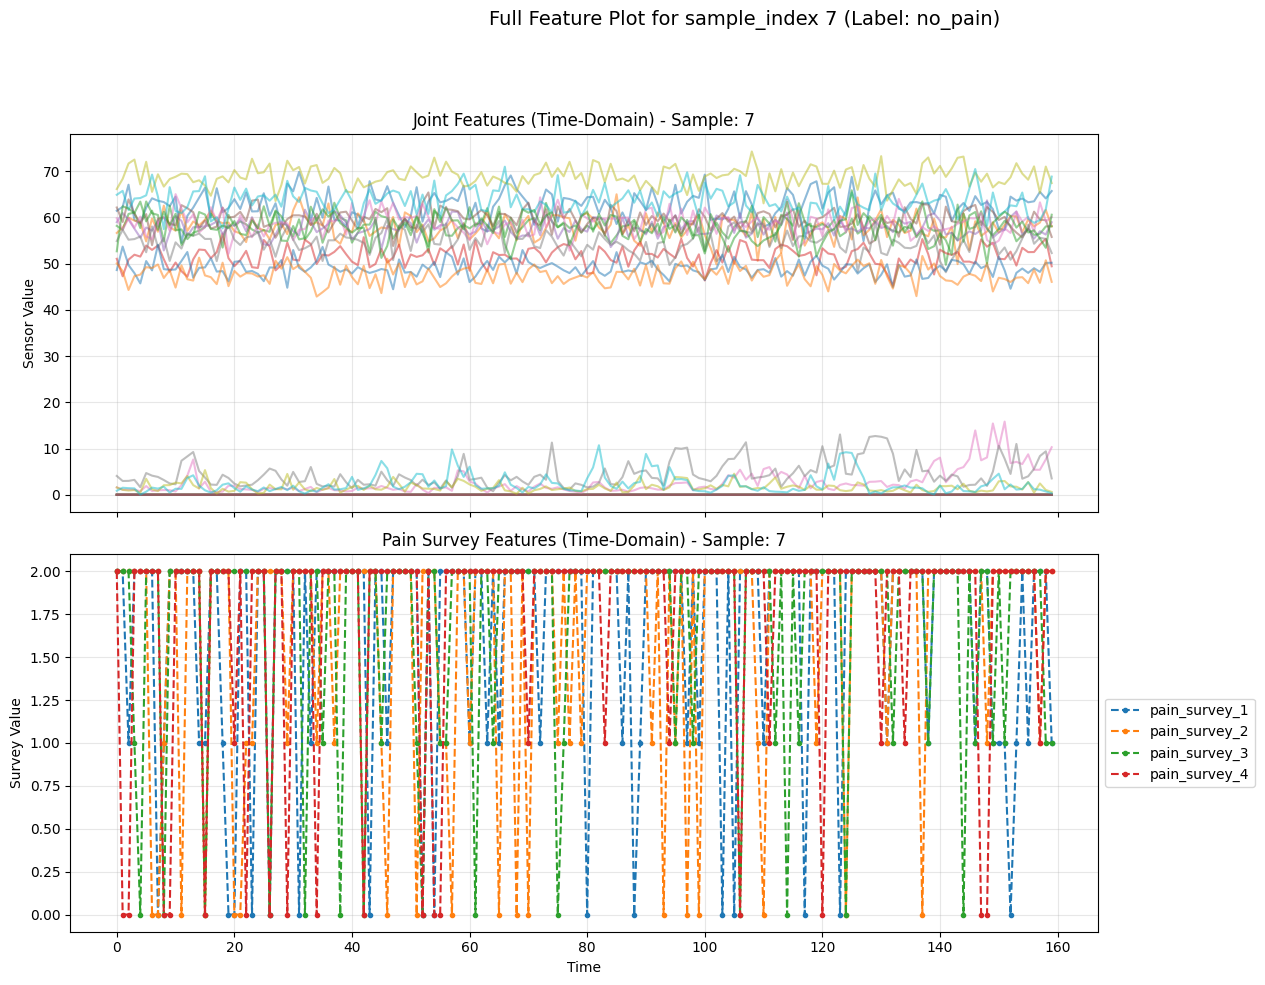

In [266]:

print("--- Plotting a single sample's features ---")

plot_sid = train_sids[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# 2. Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')


# 4. Create the plot with 2 subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

for col in joint_cols: 
    ax1.plot(sample_df['time'], sample_df[col]*180 / math.pi, label=col, alpha=0.5)
ax1.set_title(f"Joint Features (Time-Domain) - Sample: {plot_sid}")
ax1.set_ylabel("Sensor Value")
ax1.grid(alpha=0.3)

# 6. Plot all pain_cols on the second subplot (Time-Domain)
for col in pain_cols:
    ax2.plot(sample_df['time'], sample_df[col], label=col, linestyle='--', marker='o', markersize=3)
ax2.set_title(f"Pain Survey Features (Time-Domain) - Sample: {plot_sid}")
ax2.set_xlabel("Time")
ax2.set_ylabel("Survey Value")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(alpha=0.3)

fig_title = (
    f"Full Feature Plot for sample_index {plot_sid} (Label: {plot_label})\n"
)
plt.suptitle(fig_title, fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.95]) # Adjusted top margin for new title
plt.show()

### Cross Entropy weighting

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64


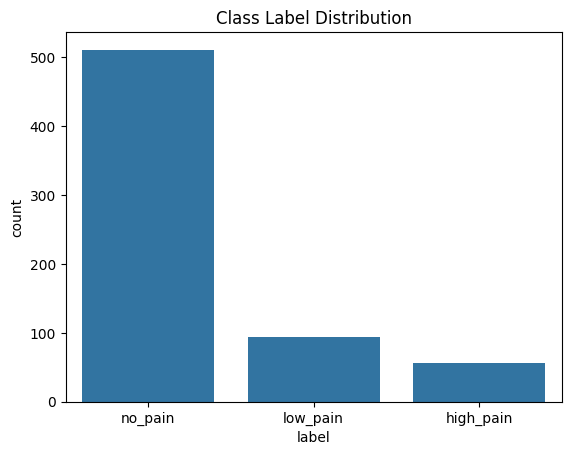


--- Calculating and Applying Class Weights ---
Label proportions:
 label
high_pain    0.084720
low_pain     0.142209
no_pain      0.773071
Name: proportion, dtype: float64
Calculated Weights:
 label
high_pain    0.586395
low_pain     0.349342
no_pain      0.064263
Name: proportion, dtype: float64
--- Applying Label Smoothing with Epsilon = 0.1 ---


In [267]:
print(df_labels['label'].value_counts(normalize=True))

sns.countplot(x='label', data=df_labels)
plt.title('Class Label Distribution')
plt.show()

weights_tensor = None
smoothing_value = 0.0 

label_proportions = df_labels['label'].value_counts(normalize=True).sort_index()

if CROSS_ENTROPY_WEIGHTING:
    print("\n--- Calculating and Applying Class Weights ---")
    print("Label proportions:\n", label_proportions)
    
    # Calculate weights (1 / proportion)
    weights = 1.0 / label_proportions
    weights = weights / weights.sum() ** WEIGHT_CE_INTENSITY
    print("Calculated Weights:\n", weights)
    
    weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
else:
    print("\n--- Using Unweighted Cross Entropy Loss ---")

if LABEL_SMOOTHING_EPSILON > 0.0:
    smoothing_value = LABEL_SMOOTHING_EPSILON
    print(f"--- Applying Label Smoothing with Epsilon = {smoothing_value} ---")
else:
    print("--- Label Smoothing is DISABLED ---")

CRITERION = nn.CrossEntropyLoss(
    weight=weights_tensor,               
    label_smoothing=smoothing_value      
)

### Window Autocorrelation

--- Autocorrelation Analysis for Sample ID: 0 ---
Generating 30 ACF plots on 1 figure(s)...


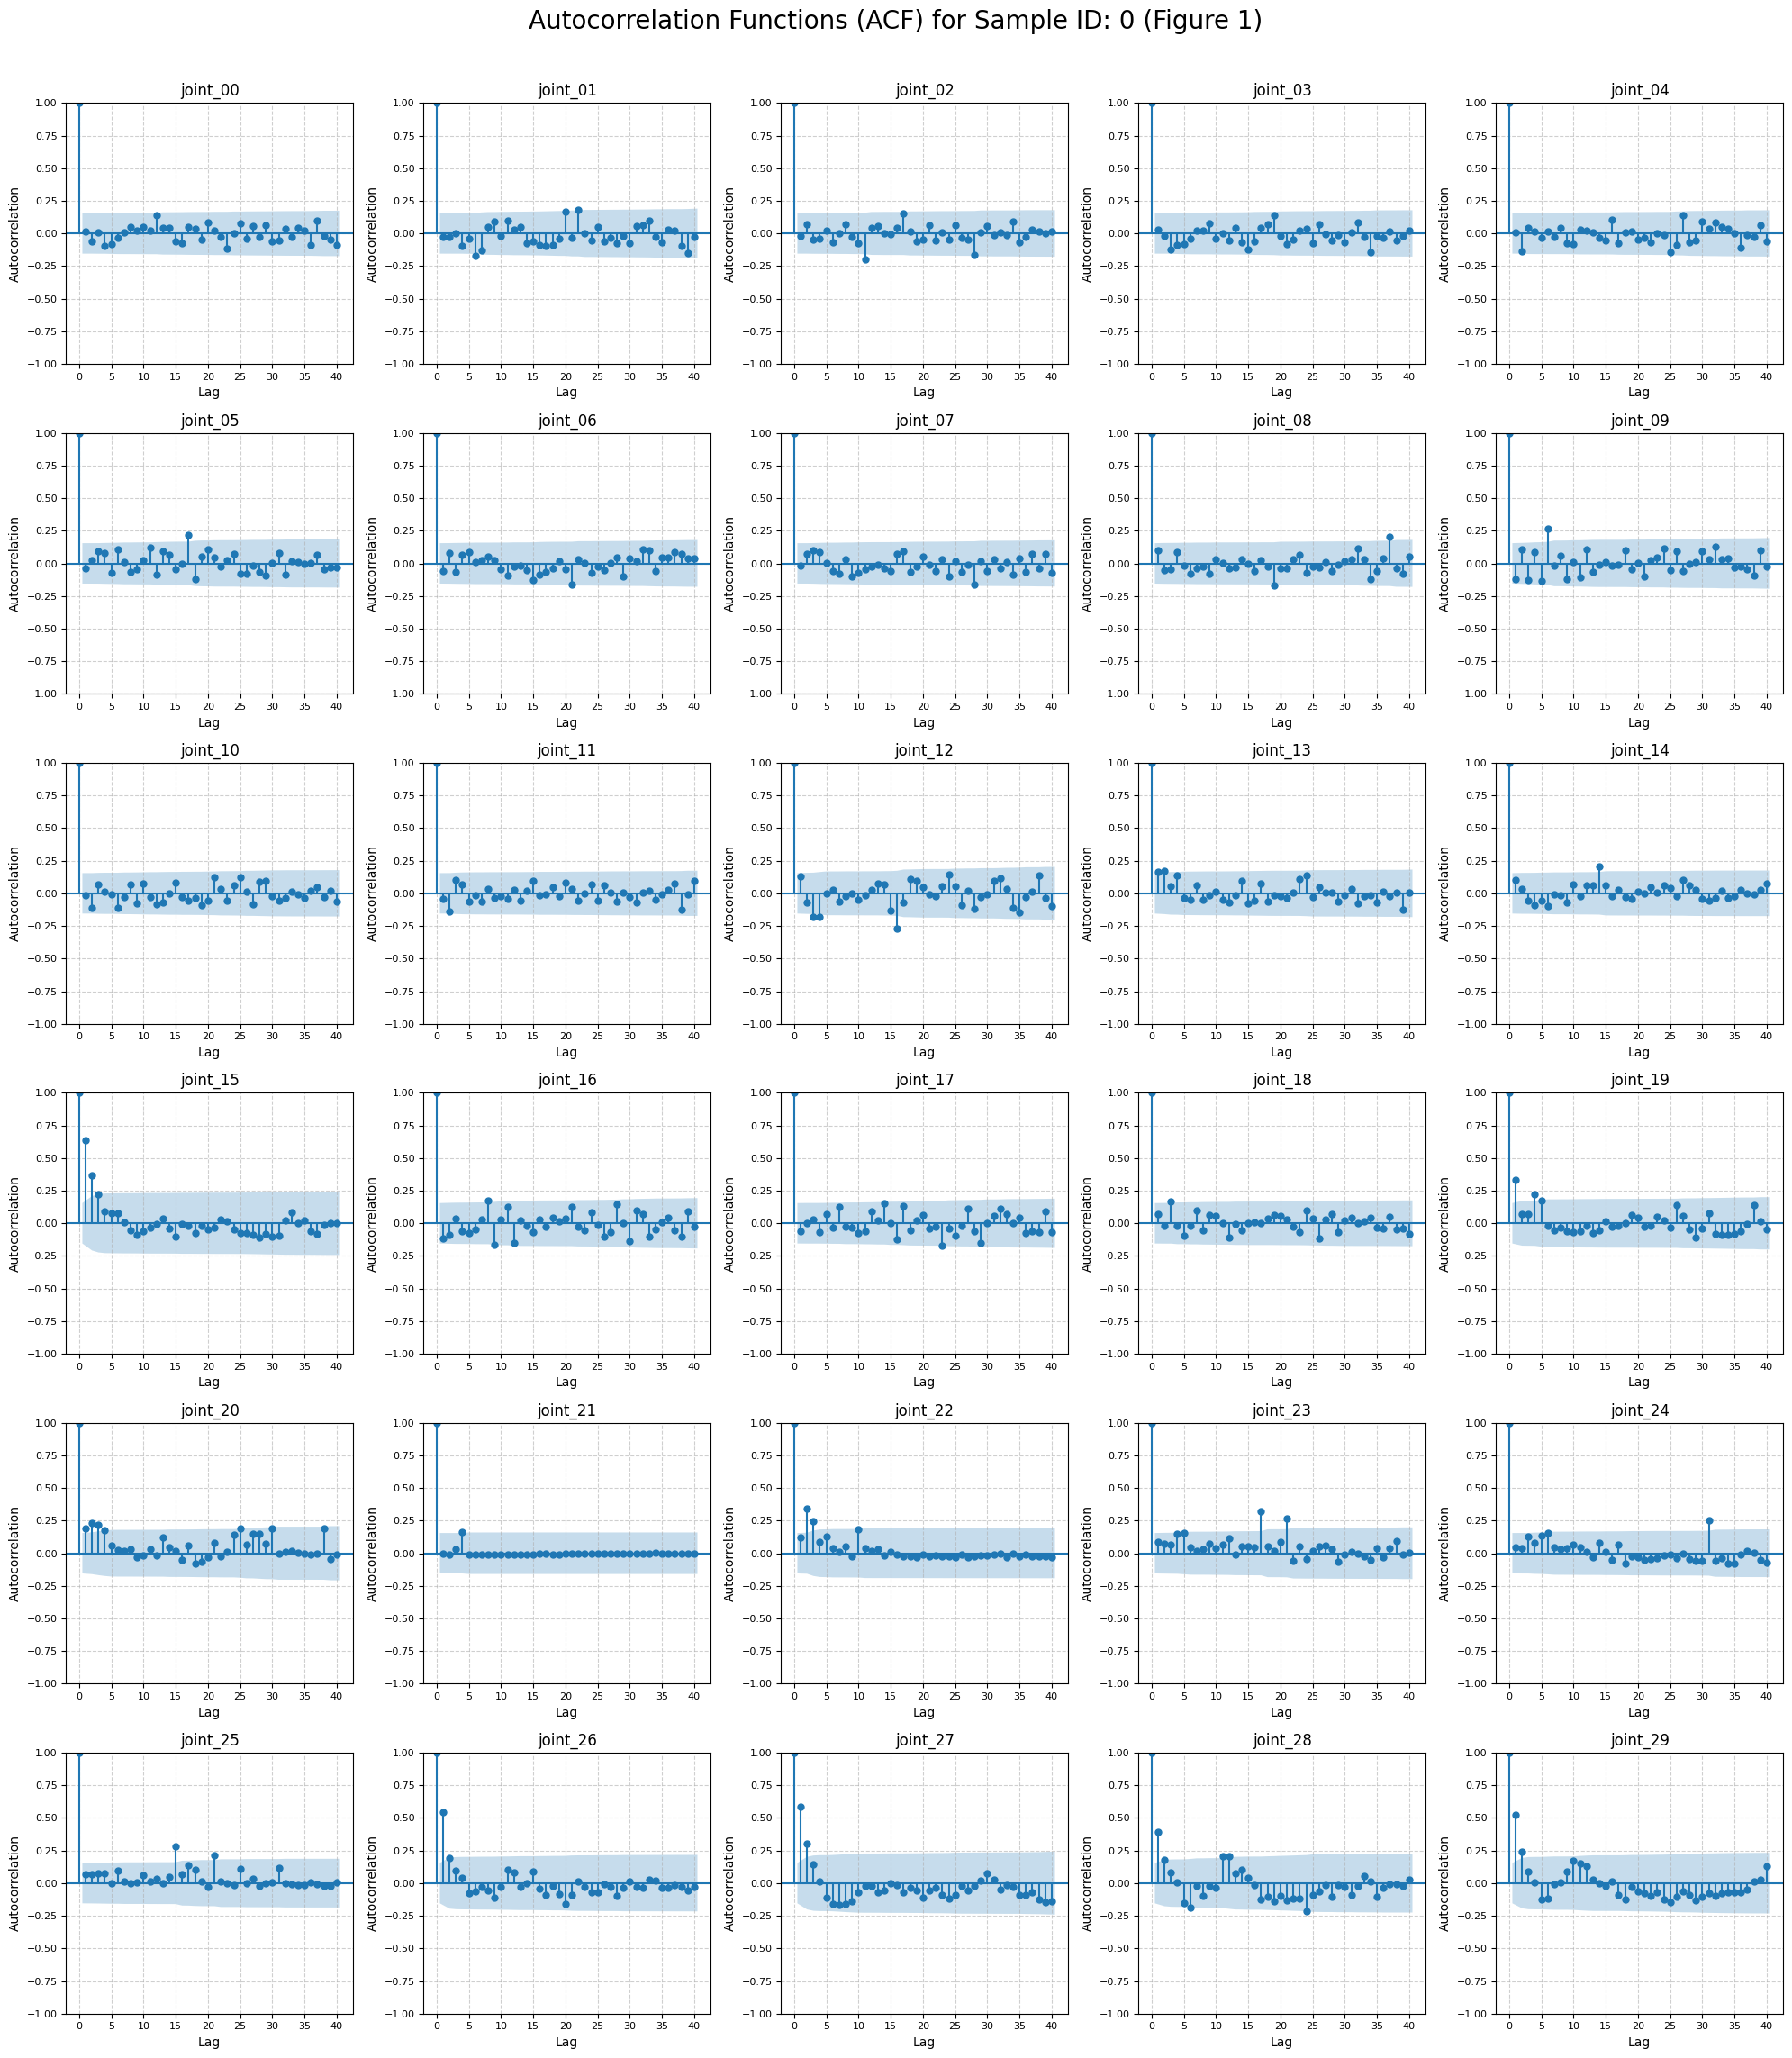



--- Interpretation ---
Examine each plot above for significant spikes (those outside the blue area).
1. DECAY: Find the point where the correlation drops into the blue zone and STAYS there. This is the 'memory span'.
2. PEAKS: Look for repeating significant spikes at regular intervals (e.g., at lag 12, 24, 36...), which indicate cycles.

Recommendation:
Your WINDOW_SIZE should be large enough to capture the LONGEST memory span you see across ALL the plots.
If most plots show the signal decaying immediately (entering the blue zone at lag 1), it confirms that a large window size is not justified by the data's autocorrelation.

Current WINDOW_SIZE is 20. Is this value consistent with the overall picture presented by these plots?


In [268]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import math

# =============================================================================
# --- 1. SETUP ---
# =============================================================================
# Select a single representative sample to analyze
sample_id = df_train['sample_index'].unique()[0]
series_data = df_train[df_train['sample_index'] == sample_id]

print(f"--- Autocorrelation Analysis for Sample ID: {sample_id} ---")

# Define grid dimensions
N_COLS = 5
N_ROWS = 6
PLOTS_PER_FIGURE = N_COLS * N_ROWS

# Calculate how many figures we'll need
n_features = len(joint_cols)
n_figures = math.ceil(n_features / PLOTS_PER_FIGURE)

print(f"Generating {n_features} ACF plots on {n_figures} figure(s)...")

# =============================================================================
# --- 2. LOOP THROUGH FEATURES AND PLOT ON SUBPLOTS ---
# =============================================================================

# Enumerate through the features to keep track of which plot we are on
for fig_num in range(n_figures):
    # Create a new figure for every 30 plots
    fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(20, 24))
    
    # Add a main title for the entire figure
    fig.suptitle(f'Autocorrelation Functions (ACF) for Sample ID: {sample_id} (Figure {fig_num + 1})', fontsize=20)
    
    # Flatten the 2D array of axes to easily iterate over it
    axes = axes.flatten()
    
    # Determine the slice of features to plot on this figure
    start_index = fig_num * PLOTS_PER_FIGURE
    end_index = start_index + PLOTS_PER_FIGURE
    features_to_plot = joint_cols[start_index:end_index]

    for i, representative_feature_col in enumerate(features_to_plot):
        ax = axes[i] # Select the current subplot

        # --- Extract the time series data for the current joint ---
        ts = series_data.sort_values('time')[representative_feature_col].values
        
        # Define the maximum lag to plot
        MAX_LAG = min(len(ts) // 4, 200) 

        # --- Plot the ACF on the designated subplot axis ---
        plot_acf(ts, lags=MAX_LAG, alpha=0.05, ax=ax, title="") # Use ax=, clear default title
        
        # --- Customize the subplot ---
        ax.set_title(f'{representative_feature_col}', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlabel('Lag', fontsize=10)
        ax.set_ylabel('Autocorrelation', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        
    # --- Clean up unused subplots on the last figure ---
    # This hides the empty boxes if you have fewer than 30 features
    num_plotted = len(features_to_plot)
    for i in range(num_plotted, len(axes)):
        axes[i].set_visible(False)
        
    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to make space for suptitle
    plt.show()


# =============================================================================
# --- 3. INTERPRETATION GUIDANCE (Applies to all plots above) ---
# =============================================================================

print("\n\n--- Interpretation ---")
print("Examine each plot above for significant spikes (those outside the blue area).")
print("1. DECAY: Find the point where the correlation drops into the blue zone and STAYS there. This is the 'memory span'.")
print("2. PEAKS: Look for repeating significant spikes at regular intervals (e.g., at lag 12, 24, 36...), which indicate cycles.")
print("\nRecommendation:")
print(f"Your WINDOW_SIZE should be large enough to capture the LONGEST memory span you see across ALL the plots.")
print("If most plots show the signal decaying immediately (entering the blue zone at lag 1), it confirms that a large window size is not justified by the data's autocorrelation.")
print(f"\nCurrent WINDOW_SIZE is {WINDOW_SIZE}. Is this value consistent with the overall picture presented by these plots?")

--- Starting Feature Importance Analysis using a Random Forest ---

Step 1: Aggregating time-series data...
Created aggregated DataFrame with shape: (661, 150)

Step 2: Merging aggregated features with labels...
Prepared data for modeling. Training on 528 samples.

Step 3: Training a Random Forest Classifier...
Random Forest Accuracy on Aggregated Data: 0.8947
(This confirms that these features have predictive power)

Step 4: Extracting and visualizing feature importances...


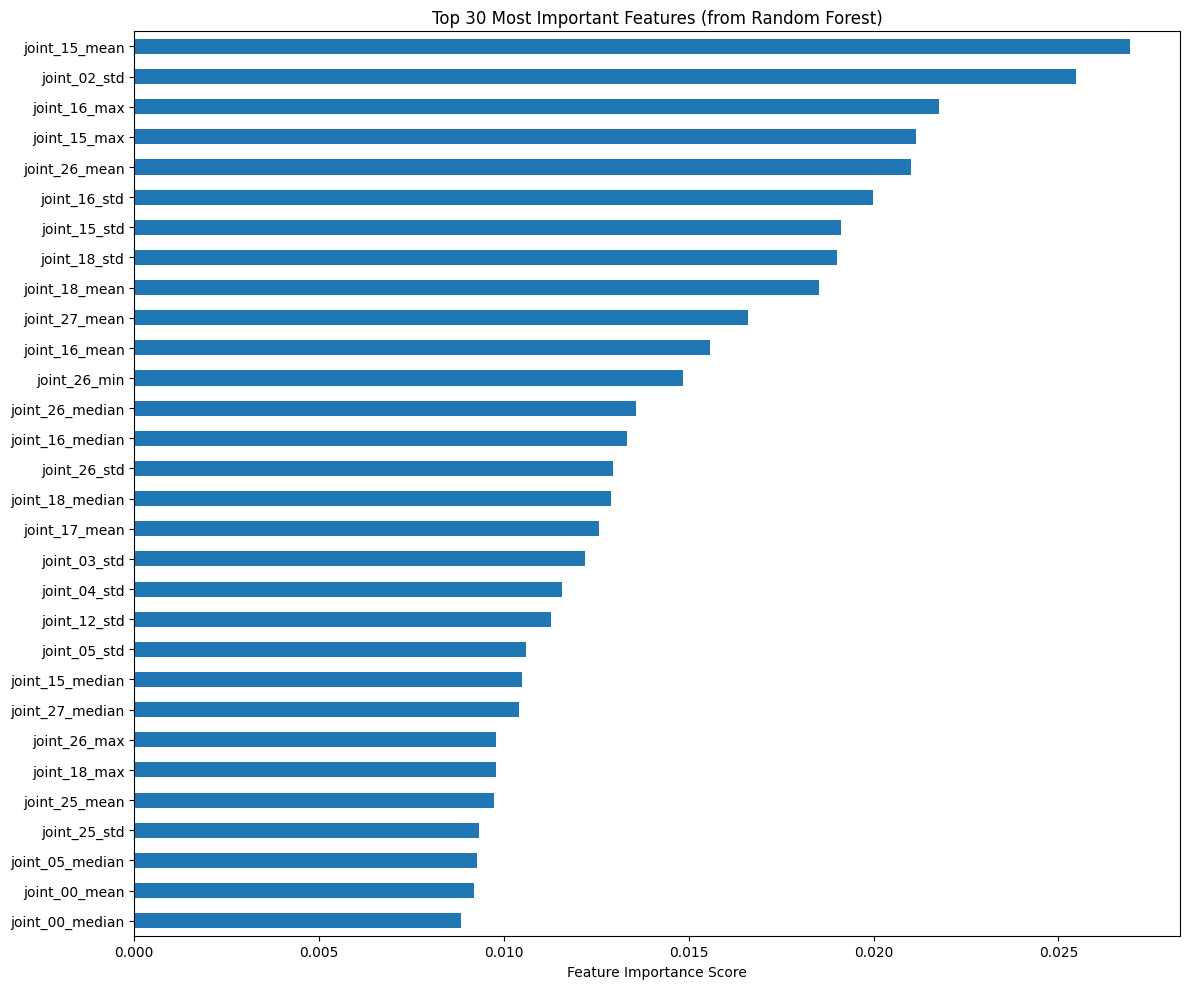


Step 5: Generating the recommended list of joints for your RNN...

Based on the analysis, here are the top 18 most predictive joints:
Recommended list of joint names: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_12', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_21', 'joint_25', 'joint_26', 'joint_27']

--- Use this vector in your main script ---
Recommended vector of joint indices: [0, 1, 2, 3, 4, 5, 6, 7, 12, 15, 16, 17, 18, 19, 21, 25, 26, 27]


In [269]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# =============================================================================
# --- PRE-REQUISITES ---
# This code assumes you have the following DataFrames loaded:
# - df_train: Your full training data with time series for each sample_index.
# - df_labels: The corresponding labels for each sample_index.
# =============================================================================

print("--- Starting Feature Importance Analysis using a Random Forest ---")

# =============================================================================
# --- 1. Aggregate Time-Series Data into a Static DataFrame ---
# =============================================================================
print("\nStep 1: Aggregating time-series data...")

# Identify all the original joint columns we want to analyze
# This ensures we analyze all 30, not just a pre-selected subset
joint_cols_to_agg = [c for c in df_train.columns if c.startswith('joint_')]
joint_cols_to_agg = joint_cols_to_agg[:-1]

# Define the set of statistics to calculate for each joint
aggregations = ['mean', 'std', 'min', 'max', 'median']

# Group by each unique sample and calculate the aggregate stats
df_agg = df_train.groupby('sample_index')[joint_cols_to_agg].agg(aggregations)

# The result has multi-level columns, e.g., ('joint_00', 'mean'). Flatten them.
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

print(f"Created aggregated DataFrame with shape: {df_agg.shape}")

# =============================================================================
# --- 2. Merge with Labels and Prepare for Modeling ---
# =============================================================================
print("\nStep 2: Merging aggregated features with labels...")

# Merge the aggregated features with the corresponding labels
# We use drop_duplicates because df_labels has one row per sample already
df_model_data = pd.merge(df_agg, df_labels.drop_duplicates(subset=['sample_index']), on='sample_index')

# Define our features (X) and target (y)
X = df_model_data.drop(columns=['sample_index', 'label'])
y = df_model_data['label']

# Perform a train-test split on this new aggregated data
# This is to validate that our features have predictive power
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Prepared data for modeling. Training on {len(X_train)} samples.")

# =============================================================================
# --- 3. Train a Random Forest and Evaluate ---
# =============================================================================
print("\nStep 3: Training a Random Forest Classifier...")

# Initialize a Random Forest model. n_jobs=-1 uses all available CPU cores.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the held-out test set
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy on Aggregated Data: {accuracy:.4f}")
print("(This confirms that these features have predictive power)")

# =============================================================================
# --- 4. Extract and Visualize Feature Importances ---
# =============================================================================
print("\nStep 4: Extracting and visualizing feature importances...")

# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a pandas Series for easier handling
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the Top 30 most important features
plt.figure(figsize=(12, 10))
# We plot the nlargest and then reverse the order so the most important is at the top
feature_importance_series.nlargest(30).iloc[::-1].plot(kind='barh')
plt.title("Top 30 Most Important Features (from Random Forest)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

# =============================================================================
# --- 5. Generate the Recommended List of Joints for your RNN ---
# =============================================================================
print("\nStep 5: Generating the recommended list of joints for your RNN...")

# Define how many of the top joints you want to select
NUM_JOINTS_TO_SELECT = 10 # You can adjust this number

# Get the top N *aggregate features* from our importance list
top_n_features = feature_importance_series.head(NUM_JOINTS_TO_SELECT * len(aggregations))

# Extract the base joint names (e.g., 'joint_27_mean' -> 'joint_27')
# Using a set automatically handles duplicates
top_joints_set = set()
for feature_name in top_n_features.index:
    base_joint_name = '_'.join(feature_name.split('_')[:2])
    top_joints_set.add(base_joint_name)

# Convert the set to a sorted list for consistency
recommended_joints_list = sorted(list(top_joints_set))

# --- FINAL RECOMMENDED LIST OF INTEGERS ---
# Find the integer indices corresponding to these recommended joint names
all_joints = sorted([c for c in df_train.columns if c.startswith('joint_')])[:-1]
joint_to_index_map = {name: i for i, name in enumerate(all_joints)}

recommended_joint_indices = sorted([joint_to_index_map[name] for name in recommended_joints_list])

print(f"\nBased on the analysis, here are the top {len(recommended_joints_list)} most predictive joints:")
print("Recommended list of joint names:", recommended_joints_list)
print("\n--- Use this vector in your main script ---")
print("Recommended vector of joint indices:", recommended_joint_indices)

## Neural Network Model

#### Pain Classifier

In [ ]:
class PainClassifier(nn.Module):
    def __init__(
        self,
        # --- INPUT SIZES ---
        joint_input_size,
        pain_input_size,

        # --- HYPERPARAMETERS ---
        hidden_size,
        num_layers,
        pain_embedding_dim,
        rnn_type,
        bidirectional,
        dropout_rate,
        num_window_idx,
        window_index_embedding_dim,
        
        static_vocab_sizes,     
        static_embedding_dim,
        num_classes=3,
  
    ):
        super().__init__()
        
        self.pain_embedding = nn.Embedding(
            num_embeddings=3,
            embedding_dim=pain_embedding_dim
        )
        self.window_index_embedding = nn.Embedding(
            num_embeddings=num_window_idx,
            embedding_dim=window_index_embedding_dim
        )

        self.static_embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=vocab_size, embedding_dim=static_embedding_dim)
            for vocab_size in [2, 2, 2]
        ])
        
        
        embedded_pain_size = pain_input_size * pain_embedding_dim
        module = rnn_map[rnn_type]
        
        rnn_input_size = joint_input_size + embedded_pain_size + window_index_embedding_dim
        dropout = dropout_rate if num_layers > 1 else 0

        self.rnn = module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )
        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout_rate)

        total_static_embedding_dim = 3 * static_embedding_dim
        classifier_input_size = (rnn_output_size * 2) + total_static_embedding_dim 

        self.classifier_hidden = nn.Linear(
            classifier_input_size, hidden_size, bias=False 
        )
        self.classifier_bn = nn.BatchNorm1d(hidden_size)
        self.classifier_activation = nn.ReLU()
        self.classifier_output = nn.Linear(hidden_size, num_classes) 


    def forward(self, x_joints, x_pain, x_window_index, x_static): 
        
        # --- 1. Process Time-Series Inputs ---
        pain_embedded = self.pain_embedding(x_pain)
        B, T, _, _ = pain_embedded.shape
        pain_embedded_flat = pain_embedded.view(B, T, -1)

        window_emb = self.window_index_embedding(x_window_index) 
        window_emb_tiled = window_emb.unsqueeze(1).repeat(1, T, 1)

        combined_sequence = torch.cat([
            x_joints, 
            pain_embedded_flat, 
            window_emb_tiled 
        ], dim=2)

        # --- 2. Run RNN ---
        rnn_out, _ = self.rnn(combined_sequence)
        rnn_out = self.dropout(rnn_out)

        # --- 3. Pool RNN Output ---
        pooled_max = torch.max(rnn_out, dim=1)[0]
        pooled_mean = torch.mean(rnn_out, dim=1)
        
        # --- 4. Process Static Inputs (Categorical) ---
        embedded_statics = []
        for i, emb_layer in enumerate(self.static_embeddings):
            feature_column = x_static[:, i]                    # Get the i-th static feature column for all samples in the batch
            embedded_statics.append(emb_layer(feature_column)) # Shape [B, static_embedding_dim]
        
        # Concatenate all embedded static features horizontally
        static_features_embedded = torch.cat(embedded_statics, dim=1) # Shape [B, num_static_features * static_embedding_dim]

        # --- 5. Fuse All Features ---
        fused_features = torch.cat([
            pooled_max, 
            pooled_mean, 
            static_features_embedded 
        ], dim=1)
        
        # --- 6. Final Classification ---
        x = self.classifier_hidden(fused_features)
        x = self.classifier_bn(x)
        x = self.classifier_activation(x)
        x = self.dropout(x) 
        logits = self.classifier_output(x)
        
        return logits

### One Epoch Training

In [271]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):
    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        x_joints, x_pain, x_window_index, x_static = inputs
        
        x_joints = x_joints.to(device)
        x_pain = x_pain.to(device)
        x_window_index = x_window_index.to(device)
        x_static = x_static.to(device) 
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x_joints, x_pain, x_window_index, x_static)
            criterion_loss = criterion(logits, targets)
            
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue
            
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm
            
        scaler.scale(total_loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()

        running_criterion_loss += criterion_loss.item() * targets.size(0)
        
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    
    all_targets_np = np.concatenate(all_targets)
    all_predictions_np = np.concatenate(all_predictions)

    epoch_f1 = f1_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_precision = precision_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    
    return epoch_loss, epoch_f1, epoch_precision, epoch_recall


### One Epoch Validation

In [272]:

def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    
    all_predictions = [] 
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            x_joints, x_pain, x_window_index, x_static = inputs
            
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_window_index = x_window_index.to(device)
            x_static = x_static.to(device)
            targets_device = targets.to(device) 

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_joints, x_pain, x_window_index, x_static)
                loss = criterion(logits, targets_device)

            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            
            running_loss += loss.item() * targets.size(0)
            all_targets.append(targets.cpu().numpy()) 

    epoch_loss = running_loss / len(val_loader.dataset)
    
    all_targets_np = np.concatenate(all_targets)
    all_predictions_np = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_precision = precision_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_np, all_predictions_np, average='weighted', zero_division=0)
    
    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

### Neural Network Fitting

In [286]:
import torch
import numpy as np
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Make sure you have these functions defined in your script:
# from your_file import train_one_epoch, validate_one_epoch

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    This is the fully corrected 'fit' function that can now handle
    val_loader being set to None (for full dataset training).
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    if patience > 0 and val_loader is None:
        print("Warning: Patience > 0 but val_loader is None. Disabling early stopping.")
        patience = 0
    
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
    
    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):

        # --- 1. ALWAYS Run Training ---
        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda
        )

        if scheduler is not None and not isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step()
        
        if val_loader is not None:
            val_loss, val_f1, val_precision, val_recall = validate_one_epoch(model, val_loader, criterion, device)
        else:
            val_loss, val_f1, val_precision, val_recall = (float('nan'), 0.0, 0.0, 0.0)

        # 3. Log history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)

        if writer is not None:
            # Log training metrics
            writer.add_scalar(f"{experiment_name}/Loss/train", train_loss, epoch)
            writer.add_scalar(f"{experiment_name}/F1/train", train_f1, epoch)
            
            if not np.isnan(val_loss):
                writer.add_scalar(f"{experiment_name}/Loss/val", val_loss, epoch)
                writer.add_scalar(f"{experiment_name}/F1/val", val_f1, epoch)
            
            # Log learning rate
            writer.add_scalar(f"{experiment_name}/learning_rate", optimizer.param_groups[0]['lr'], epoch)

            # (Your histogram logging logic)
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isfinite(param.grad).all(): # Add safety check
                        writer.add_histogram(f"{experiment_name}/Gradients/{name}", param.grad, epoch)
                if param.data is not None:
                    if torch.isfinite(param.data).all(): # Add safety check
                        writer.add_histogram(f"{experiment_name}/Weights/{name}", param.data, epoch)

        if scheduler is not None and isinstance(scheduler, ReduceLROnPlateau):
            if not np.isnan(val_loss):
                current_metric = training_history[evaluation_metric][-1]
                scheduler.step(current_metric)
            
        # 4. Print results
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                
                # --- START OF PATCH ---
                if val_loader is not None:
                    print(f"Epoch {epoch:3d}/{epochs} | "
                          f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                          f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}")
                else:
                    # Print training-only log
                    print(f"Epoch {epoch:3d}/{epochs} | "
                          f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f}")
                
        # 5. Early stopping
        if patience > 0 and val_loader is not None:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                
                save_path = "models/" + experiment_name + '_model.pt'
                save_dir = os.path.dirname(save_path)
                os.makedirs(save_dir, exist_ok=True)
                
                torch.save(model.state_dict(), save_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # 6. Restore best weights
    best_model_path = "models/" + experiment_name + '_model.pt'
    
    if restore_best_weights and patience > 0 and val_loader is not None:
        try:
            model.load_state_dict(torch.load(best_model_path))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
            print("No model checkpoint was saved (all scores were NaN or errors).")
    
    # --- START OF PATCH ---
    # Save the *final* model if patience was 0 (i.e., for full dataset training)
    if patience == 0:
    # --- END OF PATCH ---
        save_dir = os.path.dirname(best_model_path)
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved final model (from epoch {epochs}) to {best_model_path}")

    if writer is not None:
        writer.close()

    return model, training_history

### Tools

In [274]:

def predict_and_log_full_dataset(model, data_loader, sample_indices_map, 
                                 output_folder, experiment_name, label_map, device, 
                                 use_hybrid_functions):
    """
    Runs prediction on the full dataset (data_loader) and logs per-sample results.
    """
    model.eval()
    all_probs = []
    window_sids = []
    
    # Map from numeric back to string labels
    inv_label_map = {v: k for k, v in label_map.items()}
    score_cols = [inv_label_map[i] for i in range(len(label_map))]
    
    # 1. Collect window-level probabilities
    with torch.no_grad():
        for i, inputs in enumerate(data_loader):
            
            # Since the data_loader is built on the final 100% data, 
            # inputs is a tuple: ((x_joints, x_pain, x_static), y_targets)
            x_joints, x_pain, x_static = inputs[0] # Get the 3 feature inputs
            
            # Move to device
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)

            # Get model outputs
            outputs = model(x_joints, x_pain, x_static)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probabilities)
            
            # Since the loader is shuffled, we need to map the batch indices 
            # back to the original sample_indices from the dataset's underlying list
            batch_size = x_joints.size(0)
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # Append the sample_indices for this batch
            if end_idx <= len(sample_indices_map):
                window_sids.extend(sample_indices_map[start_idx:end_idx])
            else:
                # Handle last batch if size is smaller
                window_sids.extend(sample_indices_map[start_idx:len(sample_indices_map)])


    all_probs = np.concatenate(all_probs)
    
    # 2. Create window-level analysis DF
    df_window_scores = pd.DataFrame(all_probs, columns=score_cols)
    df_window_scores['sample_index'] = window_sids

    # 3. Aggregate to get per-sample predictions (Mean Probability Vote)
    
    # Calculate the mean probability for each class across all windows
    mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()
    
    # Determine the predicted label (argmax of the mean probabilities)
    final_pred_str = mean_probs_per_sample[score_cols].idxmax(axis=1)
    
    # Get the confidence of the predicted label
    final_confidence = mean_probs_per_sample.max(axis=1)

    # 4. Create the final log DataFrame
    df_log = pd.DataFrame({
        'sample_index': mean_probs_per_sample.index,
        'predicted_label': final_pred_str.values,
        'confidence': final_confidence.values
    })
    
    # 5. Save the log file
    base_dir = os.path.dirname(os.path.abspath(__file__))
    path = os.path.join(base_dir, "ensemble_training", output_folder)
    os.makedirs(path, exist_ok=True)
    log_filename = os.path.join(path, f"{experiment_name}.txt")
    
    # We save a TXT file with a tab separator
    df_log.to_csv(log_filename, sep='\t', index=False)
    print(f"   [LOGGED] Individual prediction and confidence saved to {log_filename}")
    
    return df_log

### Neural Network Summary

In [275]:
import torch
import torch.nn as nn

def plot_model_summary(model, batch_size, window_size, joint_input_size, pain_input_size, num_window_idx, static_vocab_sizes):

    # --- Helper function to count parameters ---
    def count_params(module):
        if module is None:
            return "---"
        params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        return f"{params:,}" if params > 0 else "---"

    # --- Get key dimensions from the model ---
    rnn_output_size = model.rnn.hidden_size * (2 if model.rnn.bidirectional else 1)
    pain_emb_dim = model.pain_embedding.embedding_dim
    win_emb_dim = model.window_index_embedding.embedding_dim
    static_emb_dim = model.static_embeddings[0].embedding_dim
    total_static_emb_dim = len(model.static_embeddings) * static_emb_dim
    classifier_input_size = (rnn_output_size * 2) + total_static_emb_dim
    classifier_hidden_size = model.classifier_hidden.out_features
    num_classes = model.classifier_output.out_features
    num_static_features = len(static_vocab_sizes)

    def p(text, shape, module=None):
        """Helper to print formatted table rows"""
        shape_str = str(shape)
        params_str = count_params(module)
        print(f"  {text:<40} | {shape_str:<25} | {params_str:>12}")

    print("--- Model Summary (Forward Pass Trace) ---")
    print(f"  * Batch Size (B) = {batch_size}, Window Size (T) = {window_size}")
    print("=" * 80)
    print(f"  {'Layer / Operation':<40} | {'Output Shape':<25} | {'Param #':>12}")
    print("-" * 80)
    
    # 1. Inputs
    p("Inputs:", "---", None)
    p("  x_joints (float)", [batch_size, window_size, joint_input_size], None)
    p("  x_pain (long)", [batch_size, window_size, pain_input_size], None)
    p("  x_window_index (long)", [batch_size], None)
    p("  x_static (long)", [batch_size, num_static_features], None)
    print("-" * 80)

    # 2. Time-Series Processing
    p("Time-Series Embeddings:", "---", None)
    p("  pain_embedding", [batch_size, window_size, pain_input_size, pain_emb_dim], model.pain_embedding)
    p("  (view_flat)", [batch_size, window_size, pain_input_size * pain_emb_dim], None)
    p("  window_index_embedding", [batch_size, win_emb_dim], model.window_index_embedding)
    p("  (tile_window_emb)", [batch_size, window_size, win_emb_dim], None)
    
    rnn_input_shape = [batch_size, window_size, joint_input_size + (pain_input_size * pain_emb_dim) + win_emb_dim]
    p("  (combined_sequence)", rnn_input_shape, None)
    print("-" * 80)

    # 3. RNN Processing
    p("RNN (Time-Series) Processor:", "---", None)
    p(f"  {model.rnn.__class__.__name__} (self.rnn)", [batch_size, window_size, rnn_output_size], model.rnn)
    p("  (dropout)", [batch_size, window_size, rnn_output_size], model.dropout)
    p("  (pooled_max)", [batch_size, rnn_output_size], None)
    p("  (pooled_mean)", [batch_size, rnn_output_size], None)
    print("-" * 80)
    
    # 4. Static Processing
    p("Static (Categorical) Processor:", "---", None)
    p(f"  static_embeddings ({num_static_features}x)", f"{num_static_features} tensors of [{batch_size}, {static_emb_dim}]", model.static_embeddings)
    p("  (cat_static_embeddings)", [batch_size, total_static_emb_dim], None)
    print("-" * 80)

    # 5. Final Classifier
    p("Final Classifier:", "---", None)
    p("  (fused_features)", [batch_size, classifier_input_size], None)
    p("  classifier_hidden (Linear)", [batch_size, classifier_hidden_size], model.classifier_hidden)
    p("  classifier_bn (BatchNorm1d)", [batch_size, classifier_hidden_size], model.classifier_bn)
    p("  classifier_activation (ReLU)", [batch_size, classifier_hidden_size], None)
    p("  dropout (Dropout)", [batch_size, classifier_hidden_size], model.dropout)
    p("  classifier_output (Linear)", [batch_size, num_classes], model.classifier_output)
    print("=" * 80)
    
    # --- Parameter Count ---
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 80)

## Cross Validation

### K-Fold Cross Validation

In [276]:
def k_fold_cross_validation(
    df_train, df_labels, 
    joint_cols, original_joint_cols, pain_cols, label_map,

    static_cols,                
    static_vocab_sizes,         
    static_embedding_dim,  
    static_mappings,

    window_size, stride,    
    epochs, criterion, device, k, 
    batch_size, hidden_layers, hidden_size, learning_rate, 
    dropout_rate, rnn_type, bidirectional, l1_lambda, l2_lambda,
    noise_std_dev, pain_embedding_dim=PAIN_EMBEDDING_DIM,
    
    num_window_idx=num_window_idx,
    window_index_embedding_dim=WINDOW_INDEX_EMBEDDING_DIM,

    cross_entropy_weighting=CROSS_ENTROPY_WEIGHTING,
    weight_ce_intensity=WEIGHT_CE_INTENSITY,    
    label_smoothing_epsilon=LABEL_SMOOTHING_EPSILON, 
    cv_params=None,
    patience=0, evaluation_metric="val_f1", mode='max',
    restore_best_weights=True, writer=None, verbose=10, 
    experiment_name_prefix="cv",
    joint_data_min_vec=JOINT_DATA_MIN_VEC, joint_data_max_vec=JOINT_DATA_MAX_VEC,
):

    last_fold_model = None

    # Dictionaries for history
    fold_losses, fold_metrics, best_scores = {}, {}, {}
    fold_train_losses, fold_train_metrics = {}, {}
    fold_val_precision, fold_val_recall, fold_train_precision, fold_train_recall = {}, {}, {}, {}
    best_precision_scores, best_recall_scores = {}, {}
    
    # Calculate input sizes for the new model architecture
    joint_input_size = len(joint_cols)
    pain_input_size = len(pain_cols) 

    # K-Fold splitting logic
    unique_samples = df_train['sample_index'].unique()
    label_map_series = df_labels.drop_duplicates(subset=['sample_index']).set_index('sample_index')['label']
    labels_in_order = label_map_series.loc[unique_samples].values
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    folds = [unique_samples[idx] for _, idx in skf.split(unique_samples, labels_in_order)]
    
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\n--- Fold {fold_idx+1}/{k} ---")

        val_sample_id_fold = folds[fold_idx]
        train_sids_fold = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))
        
        df_train_fold = df_train[df_train['sample_index'].isin(train_sids_fold)]
        df_labels_train_fold = df_labels[df_labels['sample_index'].isin(train_sids_fold)]
        df_val_fold = df_train[df_train['sample_index'].isin(val_sample_id_fold)]
        df_labels_val_fold = df_labels[df_labels['sample_index'].isin(val_sample_id_fold)]
            
        (X_train_joint_fold, X_train_pain_fold, X_train_window_idx_fold, X_train_static_fold), y_train_fold, train_window_sids_fold = build_fixed_sequences(
            df_train_fold, df_labels_train_fold, joint_cols, pain_cols, static_cols, label_map, 
            static_mappings,
            joint_data_min_vec, joint_data_max_vec, 
            window=window_size, stride=stride
        )
        (X_val_joint_fold, X_val_pain_fold, X_val_window_idx_fold, X_val_static_fold), y_val_fold, val_window_sids_fold = build_fixed_sequences(
            df_val_fold, df_labels_val_fold, joint_cols, pain_cols, static_cols, label_map, 
            static_mappings,
            joint_data_min_vec, joint_data_max_vec,
            window=window_size, stride=stride
        )

        # Dynamic Loss Criterion logic
        if cross_entropy_weighting:
            fold_label_proportions = df_labels_train_fold['label'].value_counts(normalize=True).sort_index()
            weights = 1.0 / fold_label_proportions
            weights = weights / weights.sum() ** weight_ce_intensity
            weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
            if verbose > 0: print(f"  Dynamic Loss Weights (Intensity {weight_ce_intensity}): {weights.values}")
        else:
            weights_tensor = None
            if verbose > 0: print("  Dynamic Loss: Using unweighted criterion.")

        CRITERION_FOLD = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=label_smoothing_epsilon)
        if verbose > 0 and label_smoothing_epsilon > 0.0: print(f"  Dynamic Loss: Label Smoothing Epsilon: {label_smoothing_epsilon}")

        train_dataset = PainDataset(
            X_train_joint_fold, X_train_pain_fold, X_train_window_idx_fold, X_train_static_fold, y_train_fold, train_window_sids_fold,
            is_train=True, noise_level=noise_std_dev
        )
        val_dataset = PainDataset(
            X_val_joint_fold, X_val_pain_fold, X_val_window_idx_fold, X_val_static_fold, y_val_fold, val_window_sids_fold,
            is_train=False
        )
            
        # Instantiate the new DualClassifier
        model = PainClassifier(
            joint_input_size=len(joint_cols),
            pain_input_size=len(pain_cols),
    
            pain_embedding_dim=pain_embedding_dim,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            rnn_type=rnn_type,
            bidirectional=bidirectional,
            dropout_rate=dropout_rate,
            num_window_idx=num_window_idx,
            window_index_embedding_dim=window_index_embedding_dim,
            
            static_vocab_sizes=static_vocab_sizes,     
            static_embedding_dim=static_embedding_dim 
        ).to(device)

        last_fold_model = model

        plot_model_summary(
            model=model,
            batch_size=batch_size,
            window_size=window_size,
            joint_input_size=len(joint_cols),
            pain_input_size=len(pain_cols),
            num_window_idx=num_window_idx,
            static_vocab_sizes=[2, 2, 2] 
        )

        # DataLoader creation
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        if verbose > 0:
            print(f"  Training windows: {len(train_dataset)}")
            print(f"  Validation windows: {len(val_dataset)}")

        # Optimizer and scaler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=epochs, 
            eta_min=1e-6   
        )
        scheduler = None

        verbose_cv = cv_params.get('verbose_cv_run', 0) if cv_params else 0

        # The main training `fit` call
        _, training_history = fit(
            model=model, train_loader=train_loader, val_loader=val_loader,
            epochs=epochs, criterion=CRITERION_FOLD, optimizer=optimizer,
            scaler=fold_scaler, device=device, writer=writer,
            patience=patience, verbose=verbose_cv, l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric, mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name_prefix}/fold_{fold_idx}",
            scheduler=scheduler
        )

        # Store results for this fold
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        fold_train_losses[f"fold_{fold_idx}"] = training_history['train_loss']
        fold_train_metrics[f"fold_{fold_idx}"] = training_history['train_f1']
        fold_val_precision[f"fold_{fold_idx}"] = training_history.get('val_precision', [])
        fold_val_recall[f"fold_{fold_idx}"] = training_history.get('val_recall', [])
        fold_train_precision[f"fold_{fold_idx}"] = training_history.get('train_precision', [])
        fold_train_recall[f"fold_{fold_idx}"] = training_history.get('train_recall', [])
        
        if training_history['val_f1']:
            best_epoch_idx = np.argmax(training_history['val_f1'])
            best_scores[f"fold_{fold_idx}"] = training_history['val_f1'][best_epoch_idx]
            if 'val_precision' in training_history and len(training_history['val_precision']) > best_epoch_idx:
                best_precision_scores[f"fold_{fold_idx}"] = training_history['val_precision'][best_epoch_idx]
            if 'val_recall' in training_history and len(training_history['val_recall']) > best_epoch_idx:
                best_recall_scores[f"fold_{fold_idx}"] = training_history['val_recall'][best_epoch_idx]
        else:
            best_scores[f"fold_{fold_idx}"] = 0.0
            best_precision_scores[f"fold_{fold_idx}"] = 0.0
            best_recall_scores[f"fold_{fold_idx}"] = 0.0

    # Calculate mean/std across all folds
    all_best_scores = list(best_scores.values())
    best_scores["mean"] = np.mean(all_best_scores)
    best_scores["std"] = np.std(all_best_scores)

    all_best_precision_scores = list(best_precision_scores.values())
    best_precision_scores["mean"] = np.mean(all_best_precision_scores)
    best_precision_scores["std"] = np.std(all_best_precision_scores)

    all_best_recall_scores = list(best_recall_scores.values())
    best_recall_scores["mean"] = np.mean(all_best_recall_scores)
    best_recall_scores["std"] = np.std(all_best_recall_scores)

    if verbose > 0:
        print(f"\nCross-validation F1 score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")
        print(f"Cross-validation Precision score: {best_precision_scores['mean']:.4f} ± {best_precision_scores['std']:.4f}")
        print(f"Cross-validation Recall score: {best_recall_scores['mean']:.4f} ± {best_recall_scores['std']:.4f}")

    # Return all history dictionaries
    return (
        fold_losses, fold_metrics, best_scores, 
        fold_train_losses, fold_train_metrics,
        fold_val_precision, fold_val_recall,
        fold_train_precision, fold_train_recall,
        best_precision_scores, best_recall_scores,
        last_fold_model
    )

### K-Fold Training

In [277]:
if CROSS_VALIDATION_TRAINING:
    cv_params_direct = {
        'epochs': EPOCHS,
        'k': K,
        'patience': PATIENCE,
        'verbose_cv_run': VERBOSE_CV_RUN,
    }

    log_dir = f"runs/CV_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    writer = SummaryWriter(log_dir=log_dir)
    print(f"--- TensorBoard dashboard running ---")
    print(f"Run the following in your terminal to view:")
    print(f"tensorboard --logdir={log_dir}")

    print("Starting direct K-Fold Cross-Validation on the Hybrid Model...")

    (   fold_losses, fold_metrics, best_scores, 
        fold_train_losses, fold_train_metrics, 
        fold_val_precision, fold_val_recall, 
        fold_train_precision, fold_train_recall, 
        best_precision_scores, best_recall_scores,
        model
    ) = k_fold_cross_validation(
        df_train=df_train,df_labels=df_labels,
        joint_cols=joint_cols, original_joint_cols=original_joint_cols, pain_cols=pain_cols, label_map=label_map,
        num_window_idx=num_window_idx,
        window_size=WINDOW_SIZE, stride=STRIDE,   

        static_cols=static_cols_raw,                
        static_vocab_sizes=len(static_cols_raw),         
        static_embedding_dim=STATIC_EMBEDDING_DIM,
        static_mappings=static_mappings,   
        
        epochs=EPOCHS,
        criterion=CRITERION,
        device=device,
        k=K,

        batch_size=BATCH_SIZE,
        hidden_layers=HIDDEN_LAYERS,
        hidden_size=HIDDEN_SIZE,
        learning_rate=LEARNING_RATE,
        dropout_rate=DROPOUT_RATE,
        rnn_type=RNN_TYPE,
        bidirectional=BIDIRECTIONAL,
        l1_lambda=L1_LAMBDA,
        l2_lambda=L2_LAMBDA, 
        pain_embedding_dim=PAIN_EMBEDDING_DIM,
        noise_std_dev=NOISE_STD_DEV,

        window_index_embedding_dim=WINDOW_INDEX_EMBEDDING_DIM,

        # CV Control Params
        cv_params=cv_params_direct,
        patience=PATIENCE,
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        verbose=VERBOSE,
        experiment_name_prefix="direct_cv",

        writer=writer,

        joint_data_min_vec=JOINT_DATA_MIN_VEC, joint_data_max_vec=JOINT_DATA_MAX_VEC
    )

    writer.add_hparams(
        hparam_dict={
            'lr': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'window_size': WINDOW_SIZE,
            'stride': STRIDE,
            'hidden_size': HIDDEN_SIZE,
            'num_layers': HIDDEN_LAYERS,
            'dropout': DROPOUT_RATE,
            'l2': L2_LAMBDA,
            'pain_emb_dim': PAIN_EMBEDDING_DIM,
            'window_emb_dim': WINDOW_INDEX_EMBEDDING_DIM
        },
        metric_dict={ # Log the final mean results
            'final_mean_f1': best_scores['mean'],
            'final_mean_precision': best_precision_scores['mean'],
            'final_mean_recall': best_recall_scores['mean']
        }
    )


    print("K-Fold complete. Logging final embeddings and HParams...")
    
    window_idx_tensor = torch.arange(num_window_idx).to(device)
    window_vectors = model.window_index_embedding(window_idx_tensor).detach()
    window_labels = [f"window_{i}" for i in range(num_window_idx)]
    
    writer.add_embedding(
        mat=window_vectors,
        metadata=window_labels,
        tag="Window Index Embedding"
    )

    pain_idx_tensor = torch.arange(3).to(device)
    pain_vectors = model.pain_embedding.weight.detach() 
    pain_labels = [inverse_label_map[i] for i in range(3)] 

    writer.add_embedding(
        mat=pain_vectors,
        metadata=pain_labels,
        tag="Pain Category Embedding"
    )

    writer.add_hparams(
        hparam_dict={ # Log all your hyperparameters
            'lr': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'window_size': WINDOW_SIZE,
            'stride': STRIDE,
            'hidden_size': HIDDEN_SIZE,
            'num_layers': HIDDEN_LAYERS,
            'dropout': DROPOUT_RATE,
            'l2': L2_LAMBDA,
            'pain_emb_dim': PAIN_EMBEDDING_DIM,
            'window_emb_dim': WINDOW_INDEX_EMBEDDING_DIM
        },
        metric_dict={ # Log the final mean results
            'final_mean_f1': best_scores['mean'],
            'final_mean_precision': best_precision_scores['mean'],
            'final_mean_recall': best_recall_scores['mean']
        }
    )
    writer.close()

    print("\nDirect K-Fold Cross-Validation Complete.")
    print(f"Mean Per-Sample F1 Score across {K} folds: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

--- TensorBoard dashboard running ---
Run the following in your terminal to view:
tensorboard --logdir=runs/CV_2025-11-13_18-11-58
Starting direct K-Fold Cross-Validation on the Hybrid Model...

--- Fold 1/5 ---
  Dynamic Loss Weights (Intensity 1.0): [0.59284185 0.34322423 0.06393392]
  Dynamic Loss: Label Smoothing Epsilon: 0.1
--- Model Summary (Forward Pass Trace) ---
  * Batch Size (B) = 32, Window Size (T) = 20
  Layer / Operation                        | Output Shape              |      Param #
--------------------------------------------------------------------------------
  Inputs:                                  | ---                       |          ---
    x_joints (float)                       | [32, 20, 30]              |          ---
    x_pain (long)                          | [32, 20, 4]               |          ---
    x_window_index (long)                  | [32]                      |          ---
    x_static (long)                        | [32, 3]                

### Plot Cross Validation Results

Plotting CV Stability (Training vs. Validation)...


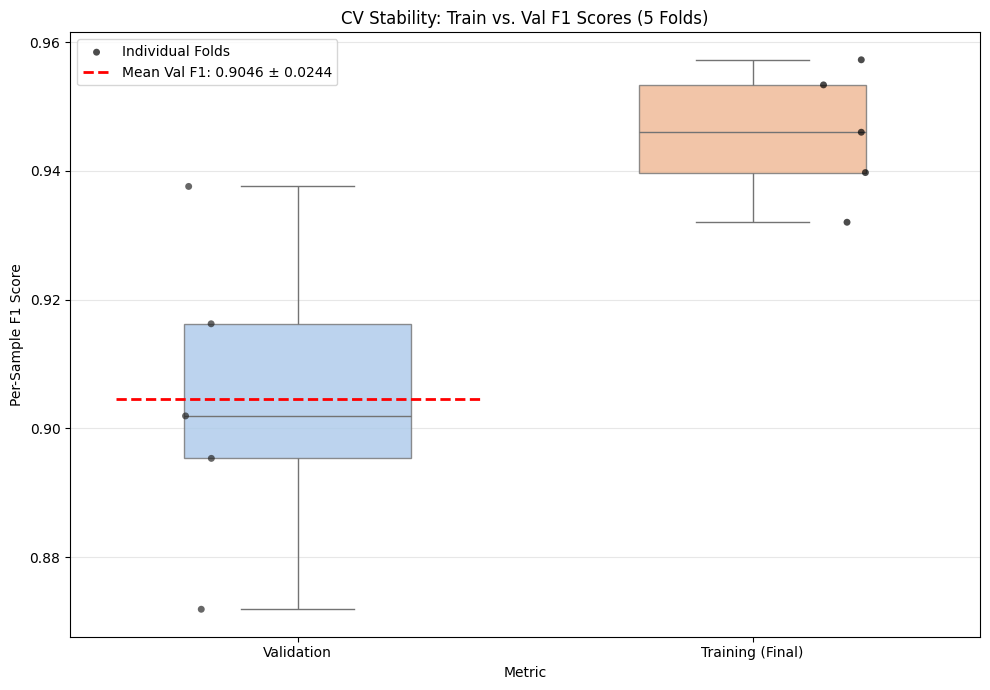

Plotting CV Learning Curves (Mean ± Std Dev)...
Successfully saved learning curve plot to cross_validation_log/experiment_2025-11-13 18:35:25.png


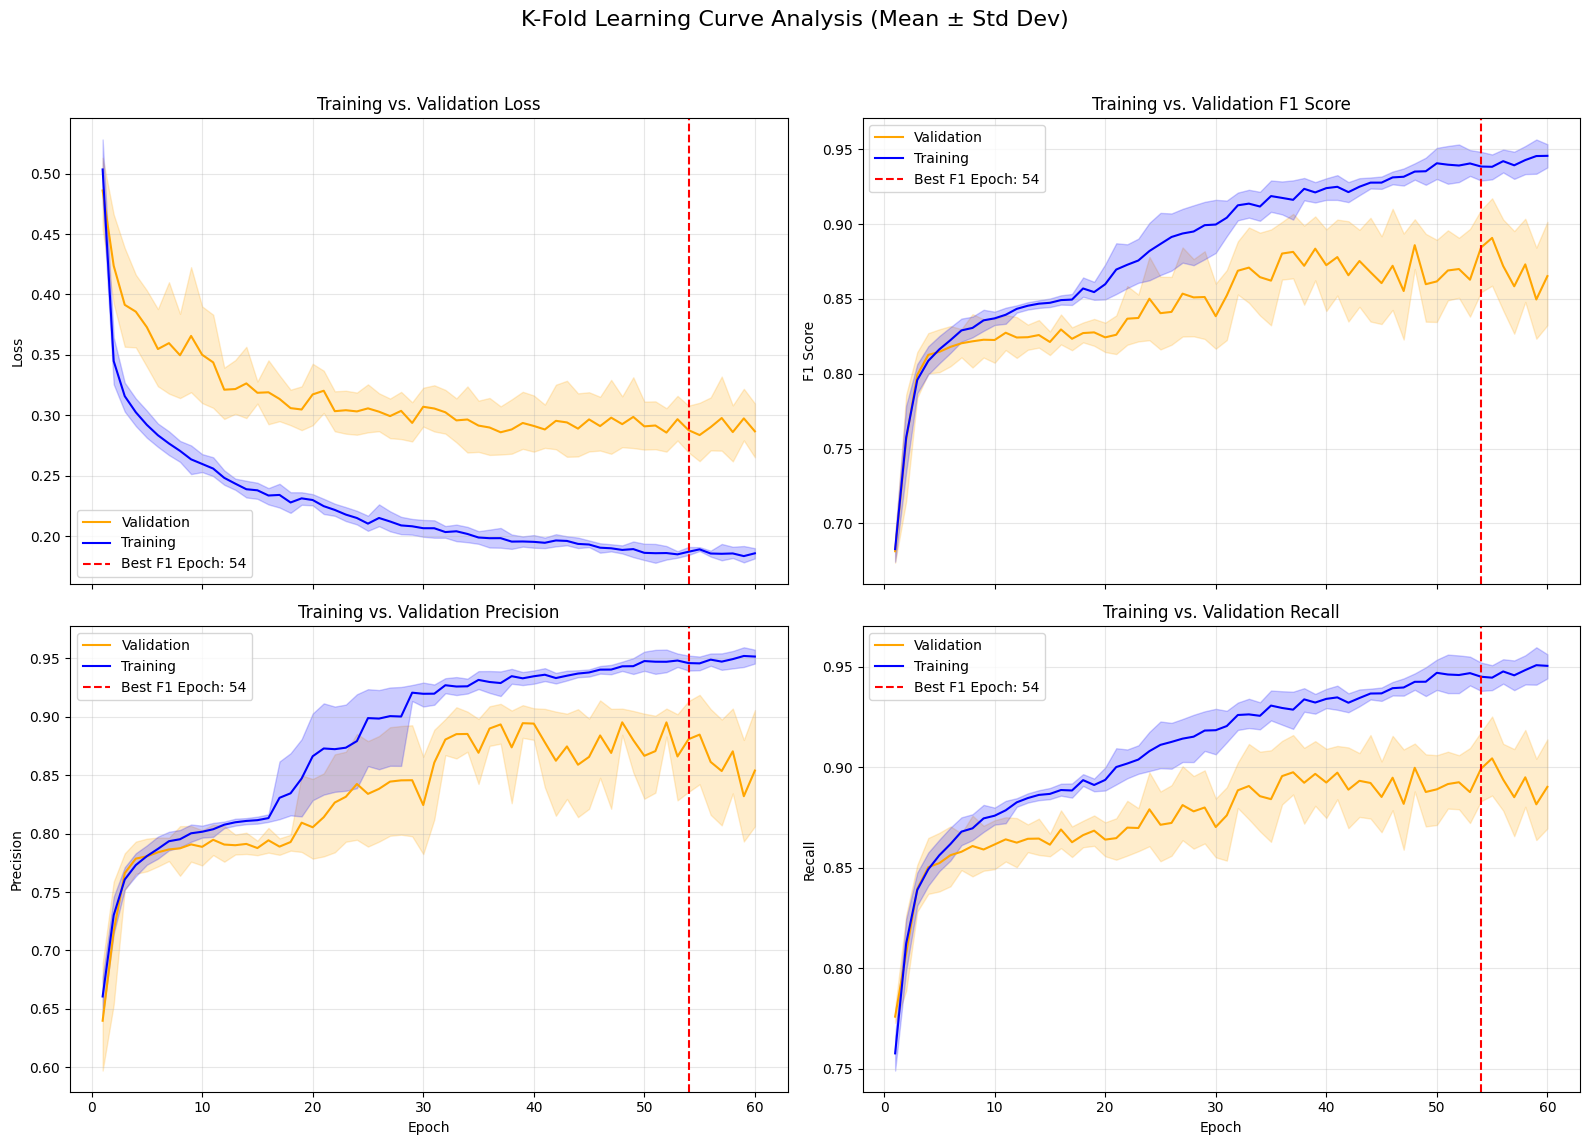

54


In [290]:


def plot_cv_stability(best_scores_dict, k_splits, fold_train_metrics_dict=None, figsize=(10, 7)):

    # 1. Extract Validation scores
    val_scores = [
        best_scores_dict[f'fold_{i}'] 
        for i in range(k_splits) 
        if f'fold_{i}' in best_scores_dict
    ]
    if not val_scores:
        print("Warning: No validation fold scores found. Cannot plot stability.")
        return
    df_val = pd.DataFrame({'F1 Score': val_scores, 'Metric': 'Validation'})
    
    # 2. Process Training scores (if provided)
    if fold_train_metrics_dict:
        train_scores = [
            history[-1] for i in range(k_splits) 
            if (history := fold_train_metrics_dict.get(f'fold_{i}'))
        ]
        df_train = pd.DataFrame({'F1 Score': train_scores, 'Metric': 'Training (Final)'})
        df_plot = pd.concat([df_val, df_train])
        x_axis = "Metric"
        title = f'CV Stability: Train vs. Val F1 Scores ({k_splits} Folds)'
    else:
        df_plot = df_val
        x_axis = None
        title = f'CV Stability: Validation F1 Score ({k_splits} Folds)'

    # 3. Create its own plot
    plt.figure(figsize=figsize)
    ax = plt.gca() # Get current axis
    
    sns.boxplot(
        x=x_axis, y='F1 Score', data=df_plot, 
        palette='pastel', width=0.5, boxprops=dict(alpha=0.8), ax=ax,
        hue=x_axis, legend=False 
    )
    
    # Stripplot (This is the new fix)
    sns.stripplot(
        x=x_axis, y='F1 Score', data=df_plot, 
        alpha=0.7, jitter=0.1, 
        label='Individual Folds', dodge=True, ax=ax,
        hue=x_axis, legend=False,
        palette='dark:black'  
    )

    # 4. Add mean line for Validation
    val_mean = df_val['F1 Score'].mean()
    val_std = df_val['F1 Score'].std()
    
    if x_axis: # Side-by-side plot
        ax.axhline(val_mean, color='red', linestyle='--', linewidth=2, 
                   xmin=0.05, xmax=0.45, 
                   label=f'Mean Val F1: {val_mean:.4f} ± {val_std:.4f}')
    else: # Single plot
        ax.axhline(val_mean, color='red', linestyle='--', linewidth=2,
                   label=f'Mean Val F1: {val_mean:.4f} ± {val_std:.4f}')

    ax.set_title(title)
    ax.set_ylabel('Per-Sample F1 Score')
    ax.set_xlabel('Metric')
    ax.grid(alpha=0.3, axis='y')
    
    # Combine legends
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.tight_layout()
    plt.show()


def plot_cv_learning_curves(
    fold_val_metrics_dict, fold_train_metrics_dict,
    fold_val_losses_dict,fold_train_losses_dict,
    fold_val_precision_dict,fold_train_precision_dict,
    fold_val_recall_dict,fold_train_recall_dict,
    logtime, 
    figsize=(16, 12),
):
    """
    Creates a 2x2 subplot dashboard showing:
    [0,0] = Loss (Train vs. Val)
    [0,1] = F1 Score (Train vs. Val)
    [1,0] = Precision (Train vs. Val)
    [1,1] = Recall (Train vs. Val)
    
    All plots show the Mean ± Std Dev and the best F1 epoch.
    """
    
    def process_data(val_dict, train_dict, metric_name):
        df_val = pd.DataFrame.from_dict(val_dict, orient='index').transpose()
        df_val = df_val.melt(ignore_index=False, var_name='Fold', value_name=metric_name).reset_index().rename(columns={'index':'Epoch'})
        df_val = df_val.dropna()
        df_val['Metric'] = 'Validation'
        
        df_train = pd.DataFrame.from_dict(train_dict, orient='index').transpose()
        df_train = df_train.melt(ignore_index=False, var_name='Fold', value_name=metric_name).reset_index().rename(columns={'index':'Epoch'})
        df_train = df_train.dropna()
        df_train['Metric'] = 'Training'
        
        df_combined = pd.concat([df_val, df_train])
        df_combined['Epoch'] = df_combined['Epoch'] + 1 
        return df_combined, df_val # Return df_val separately for finding best epoch
    
    df_f1, df_val_f1 = process_data(fold_val_metrics_dict, fold_train_metrics_dict, 'F1 Score')
    df_loss, _ = process_data(fold_val_losses_dict, fold_train_losses_dict, 'Loss')
    df_precision, _ = process_data(fold_val_precision_dict, fold_train_precision_dict, 'Precision')
    df_recall, _ = process_data(fold_val_recall_dict, fold_train_recall_dict, 'Recall')

    mean_val_f1_by_epoch = df_val_f1.groupby('Epoch')['F1 Score'].mean()
    best_f1_epoch = mean_val_f1_by_epoch.idxmax()


    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    palette = {'Training': 'blue', 'Validation': 'orange'}
    
    # --- Subplot [0, 0]: Loss Curves ---
    sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Metric', palette=palette, ax=axes[0, 0])
    axes[0, 0].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[0, 0].set_title('Training vs. Validation Loss')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].legend()
    
    # --- Subplot [0, 1]: F1 Score Curves ---
    sns.lineplot(data=df_f1, x='Epoch', y='F1 Score', hue='Metric', palette=palette, ax=axes[0, 1])
    axes[0, 1].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[0, 1].set_title('Training vs. Validation F1 Score')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].legend()

    # --- Subplot [1, 0]: Precision Curves ---
    sns.lineplot(data=df_precision, x='Epoch', y='Precision', hue='Metric', palette=palette, ax=axes[1, 0])
    axes[1, 0].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[1, 0].set_title('Training vs. Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].legend()

    # --- Subplot [1, 1]: Recall Curves ---
    sns.lineplot(data=df_recall, x='Epoch', y='Recall', hue='Metric', palette=palette, ax=axes[1, 1])
    axes[1, 1].axvline(best_f1_epoch, color='red', linestyle='--', label=f'Best F1 Epoch: {best_f1_epoch}')
    axes[1, 1].set_title('Training vs. Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].legend()

    fig.suptitle('K-Fold Learning Curve Analysis (Mean ± Std Dev)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 


    folder_name = "cross_validation_log"
    os.makedirs(folder_name, exist_ok=True)
    
    file_name = f"experiment_{logtime}.png"
    file_path = os.path.join(folder_name, file_name)
    
    fig.savefig(file_path, dpi=150, bbox_inches='tight') 
    print(f"Successfully saved learning curve plot to {file_path}")

    
    plt.show()

    return best_f1_epoch



if CROSS_VALIDATION_TRAINING:

    log_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    
    print("Plotting CV Stability (Training vs. Validation)...")
    plot_cv_stability(
        best_scores, 
        k_splits=K, 
        fold_train_metrics_dict=fold_train_metrics 
    )
    
    print("Plotting CV Learning Curves (Mean ± Std Dev)...")
    best_f1_epoch = plot_cv_learning_curves(
        fold_val_metrics_dict=fold_metrics,
        fold_train_metrics_dict=fold_train_metrics,
        fold_val_losses_dict=fold_losses,
        fold_train_losses_dict=fold_train_losses,
        fold_val_precision_dict=fold_val_precision,
        fold_train_precision_dict=fold_train_precision,
        fold_val_recall_dict=fold_val_recall,
        fold_train_recall_dict=fold_train_recall,
        logtime=log_time
    )

print(best_f1_epoch)


### Save results

In [279]:

if  CROSS_VALIDATION_TRAINING:
    print("Training complete. Logging results...")
    
    experiment_name_prefix = "direct_cv"  

    folder_name = "cross_validation_log"
    os.makedirs(folder_name, exist_ok=True)
    
    file_name = f"cross_validation_history.txt"
    file_path = os.path.join(folder_name, file_name)

    
    # Get F1 stats
    mean_f1 = best_scores.get('mean', 0.0)
    std_f1 = best_scores.get('std', 0.0)
    fold_scores = [
        best_scores[k] 
        for k in best_scores 
        if k.startswith('fold_')
    ]

    # --- ADDED: Get Precision and Recall stats ---
    mean_precision = best_precision_scores.get('mean', 0.0)
    std_precision = best_precision_scores.get('std', 0.0)
    fold_precision_scores = [
        best_precision_scores[k] 
        for k in best_precision_scores
        if k.startswith('fold_')
    ]
    
    mean_recall = best_recall_scores.get('mean', 0.0)
    std_recall = best_recall_scores.get('std', 0.0)
    fold_recall_scores = [
        best_recall_scores[k] 
        for k in best_recall_scores 
        if k.startswith('fold_')
    ]
    # ---------------------------------------------

    try:
        with open(file_path, "a") as f:
            
            f.write(f"--- Log Entry: {log_time} ---\n")
            f.write(f"Experiment Name: {experiment_name_prefix} (K={K})\n")
            f.write("\n")
            
            # --- FIXED PARAMETERS ---
            f.write("Fixed Parameters:\n")
            f.write(f"  - SEED_FLAG: {USE_SEED}\n")
            f.write(f"  - SEED: {SEED}\n")
            f.write(f"  - EPOCHS: {EPOCHS}\n")
            f.write(f"  - PATIENCE: {PATIENCE}\n")
            f.write(f"  - CROSS_ENTROPY_FLAG: {CROSS_ENTROPY_WEIGHTING}\n")
            f.write(f"  - CROSS_ENTROPY_W_INTENSITY: {WEIGHT_CE_INTENSITY}\n")
            f.write(f"  - LABEL_SMOOTHING: {LABEL_SMOOTHING_EPSILON}\n")
            f.write(f"  - USED JOINTS: {SELECTED_JOINTS}\n")
            f.write(f"  - GRADIENT CLIP NORM: {GRADIENT_CLIP_NORM}\n")
            f.write("\n")
            
            # --- HYPERPARAMETERS ---
            f.write("Hyperparameters:\n")
            f.write("\n")

            f.write("  --- General Optimization ---\n")
            f.write(f"  - LEARNING_RATE: {LEARNING_RATE}\n")
            f.write(f"  - BATCH_SIZE: {BATCH_SIZE}\n")
            f.write(f"  - WINDOW_SIZE: {WINDOW_SIZE}\n")
            f.write(f"  - STRIDE: {STRIDE}\n")
            
            f.write("  --- General Regularization ---\n")
            f.write(f"  - DROPOUT_RATE: {DROPOUT_RATE}\n")
            f.write(f"  - L2_LAMBDA (Weight Decay): {L2_LAMBDA}\n")
            f.write(f"  - L1_LAMBDA: {L1_LAMBDA}\n")
            f.write(f"  - NOISE_STD_DEV (on Joints): {NOISE_STD_DEV}\n")
            f.write("\n")

            # --- Architecture Log (This is correct) ---
            f.write("  --- Pain Classifier Architecture ---\n")
            f.write(f"      - RNN_TYPE: {RNN_TYPE}\n")
            f.write(f"      - RNN_HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
            f.write(f"      - RNN_HIDDEN_SIZE: {HIDDEN_SIZE}\n")
            f.write(f"      - RNN_BIDIRECTIONAL: {BIDIRECTIONAL}\n")
            f.write(f"      - WINDOW_INDEX_EMBEDDING_DIM: {WINDOW_INDEX_EMBEDDING_DIM}\n  ")
            
            # --- ADDED: Log all CV results ---
            f.write(f"Cross-Validation Results ({K} Folds):\n")
            f.write(f"  - Best Epoch: {best_f1_epoch}\n")
            f.write(f"  - Mean Validation F1 Score: {mean_f1:.4f} (Std Dev: {std_f1:.4f})\n")
            f.write(f"  - Mean Validation Precision: {mean_precision:.4f} (Std Dev: {std_precision:.4f})\n")
            f.write(f"  - Mean Validation Recall: {mean_recall:.4f} (Std Dev: {std_recall:.4f})\n")
            f.write("\n")
            
            f.write("  - Individual Fold F1 Scores:\n")
            for i, score in enumerate(fold_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
                
            f.write("  - Individual Fold Precision Scores:\n")
            for i, score in enumerate(fold_precision_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
                
            f.write("  - Individual Fold Recall Scores:\n")
            for i, score in enumerate(fold_recall_scores):
                f.write(f"    - Fold {i+1}: {score:.4f}\n")
            
            f.write("--------------------------------------\n\n")
        
        print("Successfully wrote CV results to cross_validation_history.txt")

    except Exception as e:
        print(f"Error writing to cross_validation_history.txt: {e}")

    sys.exit(0)

Training complete. Logging results...
Successfully wrote CV results to cross_validation_history.txt


SystemExit: 0

/home/hojo/Documents/polimi/ann-challenges-2025-26/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Bayesian Search

In [ ]:
# ########################################################################
# #   DO NOT EDIT BASE_VALUES BELOW UNLESS NEW PARAMETERS ARE ADDED
# ########################################################################
BASE_VALUES = {
    # General Optimization (Updated)
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,

    # Loss Parameters (NEW/UPDATED)
    'cross_entropy_weighting': CROSS_ENTROPY_WEIGHTING, # Fixed Flag
    'weight_ce_intensity': WEIGHT_CE_INTENSITY,         
    'label_smoothing_epsilon': LABEL_SMOOTHING_EPSILON, 

    
    # Branch 1 (Joints RNN) - Updated
    'rnn_type': RNN_TYPE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'bidirectional': BIDIRECTIONAL,
    
    # Branch 2 (Pain Survey Branch) - NEW
    'pain_embedding_dim': PAIN_EMBEDDING_DIM,
    'time_embedding_dim': WINDOW_INDEX_EMBEDDING_DIM,
    
    # General Regularization (Updated)
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'noise_std_dev': NOISE_STD_DEV, 
}

# --- TUNABLE PARAMETERS ---
param_grid = {
    # Optimization
    'learning_rate': BS_LEARNING_RATE,

    'weight_ce_intensity': BS_WEIGHT_CE_INTENSITY,
    'label_smoothing_epsilon': BS_LABEL_SMOOTHING,
    
    # Branch 1 (Joints RNN)
    'hidden_layers': BS_HIDDEN_LAYERS,
    'hidden_size': BS_HIDDEN_SIZE,
    
    # Branch 2 (Pain Survey Branch)
    'pain_embedding_dim': BS_PAIN_EMBEDDING_DIM,
    'window_embedding_dim': BS_WINDOW_EMBEDDING_DIM,
    
    # Regularization
    'dropout_rate': BS_DROPOUT_RATE,
    'l2_lambda': BS_L2_LAMBDA, 
    'noise_std_dev': BS_NOISE_STD_DEV,
}

# --- FIXED PARAMETERS ---
fixed_params = {
    k: v 
    for k, v in BASE_VALUES.items() 
    if k not in param_grid
}


### Bayesian Search hyperparameter tuning

In [ ]:
if BAYESIAN_SEARCH:
    print("\n--- Starting Bayesian Hyperparameter Optimization ---")
    print("To check dashboard, run: 'optuna-dashboard sqlite:///pirate_study.db'\n")
    print("\n\n*** THIS IS THE CORRECT SCRIPT RUNNING AT 11:38 PM ***\n\n")

    def objective(trial):
        
        tuned_config = {}
        for param_name, param_val in param_grid.items():
            tuned_config[param_name] = trial.suggest_categorical(param_name, param_val)

        
        cv_params_direct = {
            'epochs': EPOCHS,
            'k': K,
            'patience': PATIENCE,
            'verbose_cv_run': VERBOSE_CV_RUN,
        }

        print(f"\n--- Starting Trial {trial.number} ---")
        for key, value in tuned_config.items():
            print(f"  > {key}: {value}")

        run_params = {**fixed_params, **tuned_config}
        
        run_params['window_size'] = int(run_params['window_size'])
        run_params['stride'] = int(run_params['stride'])
        
        config_desc = "_".join([f"{k}_{v}" for k, v in run_params.items()])
        config_hash = hashlib.sha256(config_desc.encode()).hexdigest()[:10]

        trial.set_user_attr("config_desc", config_desc)

        log_dir = f"runs/CV_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        writer = SummaryWriter(log_dir=log_dir)
        try:

            (   fold_losses, fold_metrics, best_scores, 
                fold_train_losses, fold_train_metrics, 
                fold_val_precision, fold_val_recall, 
                fold_train_precision, fold_train_recall, 
                best_precision_scores, best_recall_scores,
                model
            ) = k_fold_cross_validation(
                df_train=df_train,df_labels=df_labels,
                joint_cols=joint_cols, original_joint_cols=original_joint_cols, pain_cols=pain_cols, label_map=label_map,
                window_size=run_params['window_size'], 
                stride=run_params['stride'],    
                
                epochs=EPOCHS,
                criterion=CRITERION,
                device=device,
                k=K,

                batch_size=run_params['batch_size'],
                hidden_layers=run_params['hidden_layers'],
                hidden_size=run_params['hidden_size'],
                learning_rate=run_params['learning_rate'],
                dropout_rate=run_params['dropout_rate'],
                rnn_type=run_params['rnn_type'],
                bidirectional=run_params['bidirectional'],
                l1_lambda=run_params['l1_lambda'],
                l2_lambda=run_params['l2_lambda'], 
                pain_embedding_dim=run_params['pain_embedding_dim'],
                noise_std_dev=run_params['noise_std_dev'],
                window_index_embedding_dim=run_params['window_embedding_dim'],

                num_window_idx=num_window_idx,
,

                # CV Control Params
                cv_params=cv_params_direct,
                patience=PATIENCE,
                evaluation_metric="val_f1",
                mode='max',
                restore_best_weights=True,
                verbose=VERBOSE,
                experiment_name_prefix="direct_cv",

                writer=writer,

                joint_data_min_vec=JOINT_DATA_MIN_VEC, joint_data_max_vec=JOINT_DATA_MAX_VEC
            )
        
            mean_f1 = best_scores["mean"]
            trial.set_user_attr("mean_f1", mean_f1)

            print(f"  > Trial {trial.number} Result: Mean F1 = {mean_f1:.4f}")
            
            return -mean_f1
        
        except Exception as e:
            print(f"--- ERROR in Trial {trial.number} ---")
            print(f"Configuration: {run_params}")
            print(f"Error: {e}")
            print(f"  > Trial {trial.number} Result: F1 = 0.0 (due to error)")
            # Prune the trial by returning a very high loss (e.g., 0 F1 score)
            return 0.0 
    
    start_time = datetime.now()
    
    STORAGE_URL = "sqlite:///pirate_study.db" 
    STUDY_NAME = "bayesian_search" 

    # try:
        
    #     study = optuna.create_study(
    #         study_name=STUDY_NAME,
    #         storage=STORAGE_URL,
    #         direction="minimize",
    #         load_if_exists=True  
    #     )    
        
    #     print(f"--- Attempting to optimize study: '{STUDY_NAME}' ---")
        
    #     study.optimize(
    #         objective, 
    #         n_trials=BS_N_TRIALS, 
    #         show_progress_bar=True
    #     )
    
    # except ValueError as e:
    #     if "Cannot set different distribution kind" in str(e):
    #         print(f"\n--- WARNING: Hyperparameter space has changed! ---")
            
    #         timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    #         NEW_STUDY_NAME = f"{STUDY_NAME}_{timestamp}"
            
    #         print(f"Old study '{STUDY_NAME}' is incompatible.")
    #         print(f"Starting a new study: '{NEW_STUDY_NAME}'\n")
            
    #         study = optuna.create_study(
    #             study_name=NEW_STUDY_NAME,
    #             storage=STORAGE_URL,
    #             direction="minimize",
    #             load_if_exists=False  
    #         )
            
    #         study.optimize(
    #             objective, 
    #             n_trials=BS_N_TRIALS, 
    #             show_progress_bar=True
    #         )
    #     else:
    #         print(f"--- An unexpected ValueError occurred ---")
    #         raise e
    #         print(f"\n--- WARNING: Hyperparameter space has changed! ---")
            
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    NEW_STUDY_NAME = f"{STUDY_NAME}_{timestamp}"
    
    print(f"Old study '{STUDY_NAME}' is incompatible.")
    print(f"Starting a new study: '{NEW_STUDY_NAME}'\n")
    
    study = optuna.create_study(
        study_name=NEW_STUDY_NAME,
        storage=STORAGE_URL,
        direction="minimize",
        load_if_exists=False  
    )
    
    study.optimize(
        objective, 
        n_trials=BS_N_TRIALS, 
        show_progress_bar=True
    )
    
    end_time = datetime.now()
    total_time = end_time - start_time
    
    best_trial = study.best_trial
    best_score = -best_trial.value 
    best_config = best_trial.params
    
    print("\n--- Bayesian Optimization Complete ---")
    print(f"Best Score (Mean F1): {best_score:.4f}")
    print(f"Best Config:\n{best_config}")
    print(f"Total Runtime: {total_time}")

    with open("bayesian_search_results.txt", "a") as f:
        f.write(f"\n\n--- Bayesian Search Results Log ---\n")
        f.write(f"Timestamp: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Runtime: {total_time}\n")
        f.write(f"Total Trials: {len(study.trials)}\n")
        f.write(f"Best Validation F1 Score: {best_score:.4f}\n")
        f.write("Optimal Parameters:\n")
        for k, v in best_config.items():
            f.write(f"  {k:<25}: {v}\n")
        f.write("----------------------------------\n")

else:
    print("BAYESIAN_SEARCH is False. Skipping Bayesian Search CV.")

## Full Dataset Training

### Single training

In [291]:
if FULL_DATASET_TRAINING:
    print("\n--- FINAL TRAINING ON FULL DATASET ---")


    if 'best_f1_epoch' in locals() and best_f1_epoch > 0:
         FINAL_TRAINING_EPOCHS = best_f1_epoch
    else:
         print(f"Warning: 'OPTIMAL_EPOCHS' not found. Using default '{EPOCHS}' epochs.")
         FINAL_TRAINING_EPOCHS = EPOCHS 
    
    FINAL_EXPERIMENT_NAME = f"final_model_{FINAL_TRAINING_EPOCHS}_epochs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"Starting final training on ALL data for {FINAL_TRAINING_EPOCHS} epochs.")
    print(f"Final model will be saved as: models/{FINAL_EXPERIMENT_NAME}_model.pt")

    # --- STEP 1: PREPARE 100% OF THE TRAINING DATA ---
    print("Building sequences from 100% of training data...")
    (
        X_train_full_joint, 
        X_train_full_pain, 
        X_train_full_window_idx, 
        X_train_full_static
    ), y_train_full, train_full_sids = build_fixed_sequences(
        df_train, df_labels, 
        joint_cols, pain_cols, static_cols_raw, label_map,
        static_mappings,  
        joint_data_min_vec=JOINT_DATA_MIN_VEC,  
        joint_data_max_vec=JOINT_DATA_MAX_VEC, 
        window=WINDOW_SIZE,
        stride=STRIDE
    )

    print(f"\nTotal windows created for FINAL training: {len(y_train_full)}")

    # --- STEP 2: CREATE FINAL DATASET AND DATALOADER ---
    full_train_dataset = PainDataset(
        X_train_full_joint, 
        X_train_full_pain, 
        X_train_full_window_idx, 
        X_train_full_static, 
        y_train_full, 
        train_full_sids, 
        is_train=True, 
        noise_level=NOISE_STD_DEV
    )
    
    full_train_loader = DataLoader(
        full_train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        drop_last=True
    )
    
    # --- STEP 3: INITIALIZE THE FINAL MODEL ---
    print("Initializing final model...")
    final_model = PainClassifier(
        joint_input_size=len(joint_cols),
        pain_input_size=len(pain_cols),
        
        hidden_size=HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        pain_embedding_dim=PAIN_EMBEDDING_DIM,
        rnn_type=RNN_TYPE,
        bidirectional=BIDIRECTIONAL,
        dropout_rate=DROPOUT_RATE,
        num_window_idx=num_window_idx,
        window_index_embedding_dim=WINDOW_INDEX_EMBEDDING_DIM,
        
        static_vocab_sizes=static_vocab_sizes,
        static_embedding_dim=STATIC_EMBEDDING_DIM
    ).to(device)

    # --- STEP 4: TRAIN THE FINAL MODEL ---
    optimizer_final = torch.optim.AdamW(final_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
    scaler_final = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    scheduler_final = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_final, T_max=FINAL_TRAINING_EPOCHS)
    
    print(f"Starting final 'fit' for {FINAL_TRAINING_EPOCHS} epochs...")
    final_model, final_training_history = fit(
        model=final_model,
        train_loader=full_train_loader,
        val_loader=None,   
        epochs=FINAL_TRAINING_EPOCHS,
        criterion=CRITERION,
        optimizer=optimizer_final,
        scaler=scaler_final,
        device=device,
        verbose=VERBOSE,
        experiment_name=FINAL_EXPERIMENT_NAME,
        scheduler=scheduler_final,
        patience=0, 
        restore_best_weights=False 
    )

    model = final_model
    experiment_name = FINAL_EXPERIMENT_NAME 

    print("\n--- Final training complete. Model is ready for test prediction. ---")


--- FINAL TRAINING ON FULL DATASET ---
Starting final training on ALL data for 54 epochs.
Final model will be saved as: models/final_model_54_epochs_20251113_183543_model.pt
Building sequences from 100% of training data...

Total windows created for FINAL training: 9915
Initializing final model...
Starting final 'fit' for 54 epochs...
Training 54 epochs...
Epoch   1/54 | Train: Loss=0.4834, F1=0.6759, Prec=0.6844, Rec=0.7653
Epoch   2/54 | Train: Loss=0.3353, F1=0.7653, Prec=0.7322, Rec=0.8162
Epoch   3/54 | Train: Loss=0.3052, F1=0.8041, Prec=0.7682, Rec=0.8456
Epoch   4/54 | Train: Loss=0.2845, F1=0.8171, Prec=0.7812, Rec=0.8574
Epoch   5/54 | Train: Loss=0.2716, F1=0.8281, Prec=0.7925, Rec=0.8672
Epoch   6/54 | Train: Loss=0.2642, F1=0.8327, Prec=0.7974, Rec=0.8713
Epoch   7/54 | Train: Loss=0.2596, F1=0.8358, Prec=0.8006, Rec=0.8742
Epoch   8/54 | Train: Loss=0.2512, F1=0.8426, Prec=0.8079, Rec=0.8807
Epoch   9/54 | Train: Loss=0.2456, F1=0.8443, Prec=0.8090, Rec=0.8829
Epoch  10/

## Test Prediction

### Test set prediction

In [292]:

print("\n--- Starting Test Set Prediction (NEW) ---")

# --- 1. LOAD TEST DATA ---
# We only need df_test. The static_mappings and norm_stats are already in memory.
df_test = pd.read_csv('pirate_pain_test.csv')

# Ensure correct dtypes
float_cols = df_test.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_test[col] = df_test[col].astype(np.float32)

print(f"Loaded {len(df_test)} test rows.")

# --- 2. PREPARE TEST WINDOWS (Using the NEW build_fixed_sequences) ---
# Create a dummy labels DataFrame for the function
df_labels_test_dummy = pd.DataFrame({
    'sample_index': df_test['sample_index'].unique(), 
    'label': 'no_pain' # Placeholder, not used
})

print("Building test windows...")
(
    X_test_joint, 
    X_test_pain, 
    X_test_window_idx, 
    X_test_static
), _, test_window_sids = build_fixed_sequences(
    df_features=df_test,
    df_labels=df_labels_test_dummy,
    joint_cols=joint_cols,            # From main script
    pain_cols=pain_cols,              # From main script
    static_cols=static_cols_raw,      # From main script
    label_map=label_map,              # From main script
    static_mappings=static_mappings,  # From main script
    joint_data_min_vec=JOINT_DATA_MIN_VEC, # From main script
    joint_data_max_vec=JOINT_DATA_MAX_VEC, # From main script
    window=WINDOW_SIZE,
    stride=STRIDE
)
print(f"Created {len(X_test_joint)} test windows.") # Using y_test_dummy from the file

# --- 3. CREATE TEST DATASET AND DATALOADER (Using the NEW PainDataset) ---
# We use a dummy y_target (np.zeros) because we don't have test labels
y_test_dummy = np.zeros(len(X_test_joint))

test_dataset = PainDataset(
    X_test_joint,
    X_test_pain,
    X_test_window_idx,
    X_test_static,
    y_test_dummy,
    test_window_sids,
    is_train=False # No noise for testing
)

# drop_last=False is correct for validation/testing
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(f"Created test_loader with {len(test_loader)} batches.")


# --- 4. LOAD MODEL AND GENERATE PREDICTIONS ---
# 'model' and 'experiment_name' are set by the previous K-Fold or Full Training cell
model_path = f"models/{experiment_name}_model.pt"
print(f"Loading final trained model from {model_path}...")

# Load the state dict into the 'model' object
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except FileNotFoundError:
    print(f"ERROR: Model file not found at {model_path}")
    print("Did the 'FULL_DATASET_TRAINING' cell run correctly?")
    # Raise an error or handle as needed
    raise
except Exception as e:
    print(f"Error loading model state_dict. Did the model architecture change?")
    print(f"Error: {e}")
    raise

model.eval() # Set model to evaluation mode

all_window_probs = []
with torch.no_grad():
    # The dataloader now yields the correct 4-tuple of inputs
    for (x_j, x_p, x_w, x_s), _ in test_loader:
        
        x_j = x_j.to(device)
        x_p = x_p.to(device)
        x_w = x_w.to(device)
        x_s = x_s.to(device)
        
        # Call the model with all 4 arguments
        outputs = model(x_j, x_p, x_w, x_s)
        
        all_window_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())

all_window_probs = np.concatenate(all_window_probs, axis=0)

print("Prediction complete. Aggregating results...")

# --- 5. AGGREGATE PREDICTIONS (This logic was correct) ---
score_cols = [inverse_label_map[i] for i in range(len(label_map))]
df_window_scores = pd.DataFrame(all_window_probs, columns=score_cols)
df_window_scores['sample_index'] = test_window_sids

# Calculate the mean probability for each class across all windows
mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()

# Determine the predicted label (argmax of the mean probabilities)
final_predictions = mean_probs_per_sample.idxmax(axis=1)
final_predictions.name = 'label'
submission_df = final_predictions.reset_index()

# --- 6. CREATE SUBMISSION FILE (This logic was also correct) ---
# Ensure all test samples from the original test file are in the submission
all_test_sids_df = pd.DataFrame({'sample_index': df_test['sample_index'].unique()})

# Convert sample_index to string in both frames for a safe merge
# (Your submission cell does this, so we'll do it here)
all_test_sids_df['sample_index'] = all_test_sids_df['sample_index'].astype(str)
submission_df['sample_index'] = submission_df['sample_index'].astype(str)

submission_df = all_test_sids_df.merge(submission_df, on='sample_index', how='left')

# Fill any missing predictions (if any) with the majority class
# (We need to get the majority class from the *full* training set, 'y_train_full')
if 'y_train_full' in locals() and len(y_train_full) > 0:
    majority_class_numeric = pd.Series(y_train_full).mode().iloc[0]
else:
    # Fallback just in case y_train_full wasn't created
    majority_class_numeric = 0 
    
majority_class_label = inverse_label_map[majority_class_numeric]
    
num_missing = submission_df['label'].isna().sum()
if num_missing > 0:
    print(f"Filling {num_missing} missing predictions with majority class '{majority_class_label}'")
    submission_df['label'] = submission_df['label'].fillna(majority_class_label)

print("\n--- Test Prediction Cell Complete ---")
print("The variables 'submission_df', 'mean_probs_per_sample', and 'df_window_scores'")
print("are now ready for your 'Analysis' and 'Submission' cells.")
print("\nFinal Test Set Predictions (Head):")
print(submission_df.head())


--- Starting Test Set Prediction (NEW) ---
Loaded 211840 test rows.
Building test windows...
Created 19860 test windows.
Created test_loader with 621 batches.
Loading final trained model from models/final_model_54_epochs_20251113_183543_model.pt...
Prediction complete. Aggregating results...

--- Test Prediction Cell Complete ---
The variables 'submission_df', 'mean_probs_per_sample', and 'df_window_scores'
are now ready for your 'Analysis' and 'Submission' cells.

Final Test Set Predictions (Head):
  sample_index    label
0            0  no_pain
1            1  no_pain
2            2  no_pain
3            3  no_pain
4            4  no_pain



--- Starting Analysis & Submission ---

Aggregating window predictions using mean probability...

--- Final Test Set Predictions Summary ---
label
no_pain      0.854230
low_pain     0.129154
high_pain    0.016616
Name: proportion, dtype: float64

---


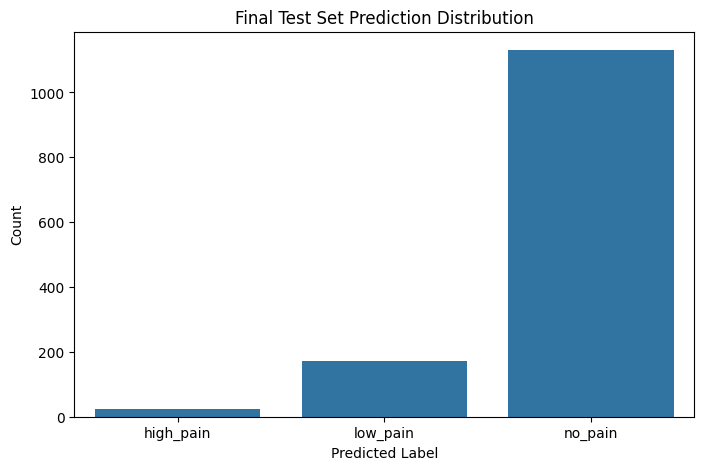


--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---
              confidence_margin   no_pain  low_pain  high_pain
sample_index                                                  
788                    0.000743  0.467883  0.468627   0.063490
659                    0.001413  0.358115  0.282356   0.359529
868                    0.002770  0.464396  0.461626   0.073978
45                     0.006135  0.381476  0.243182   0.375341
1211                   0.006809  0.486786  0.479977   0.033237




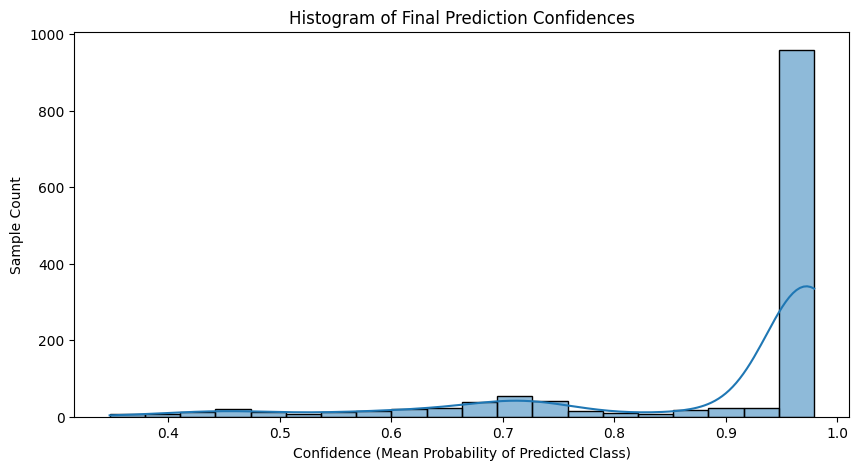


--- Plotting Window-by-Window Probabilities for Top 4 Most Confused Samples ---


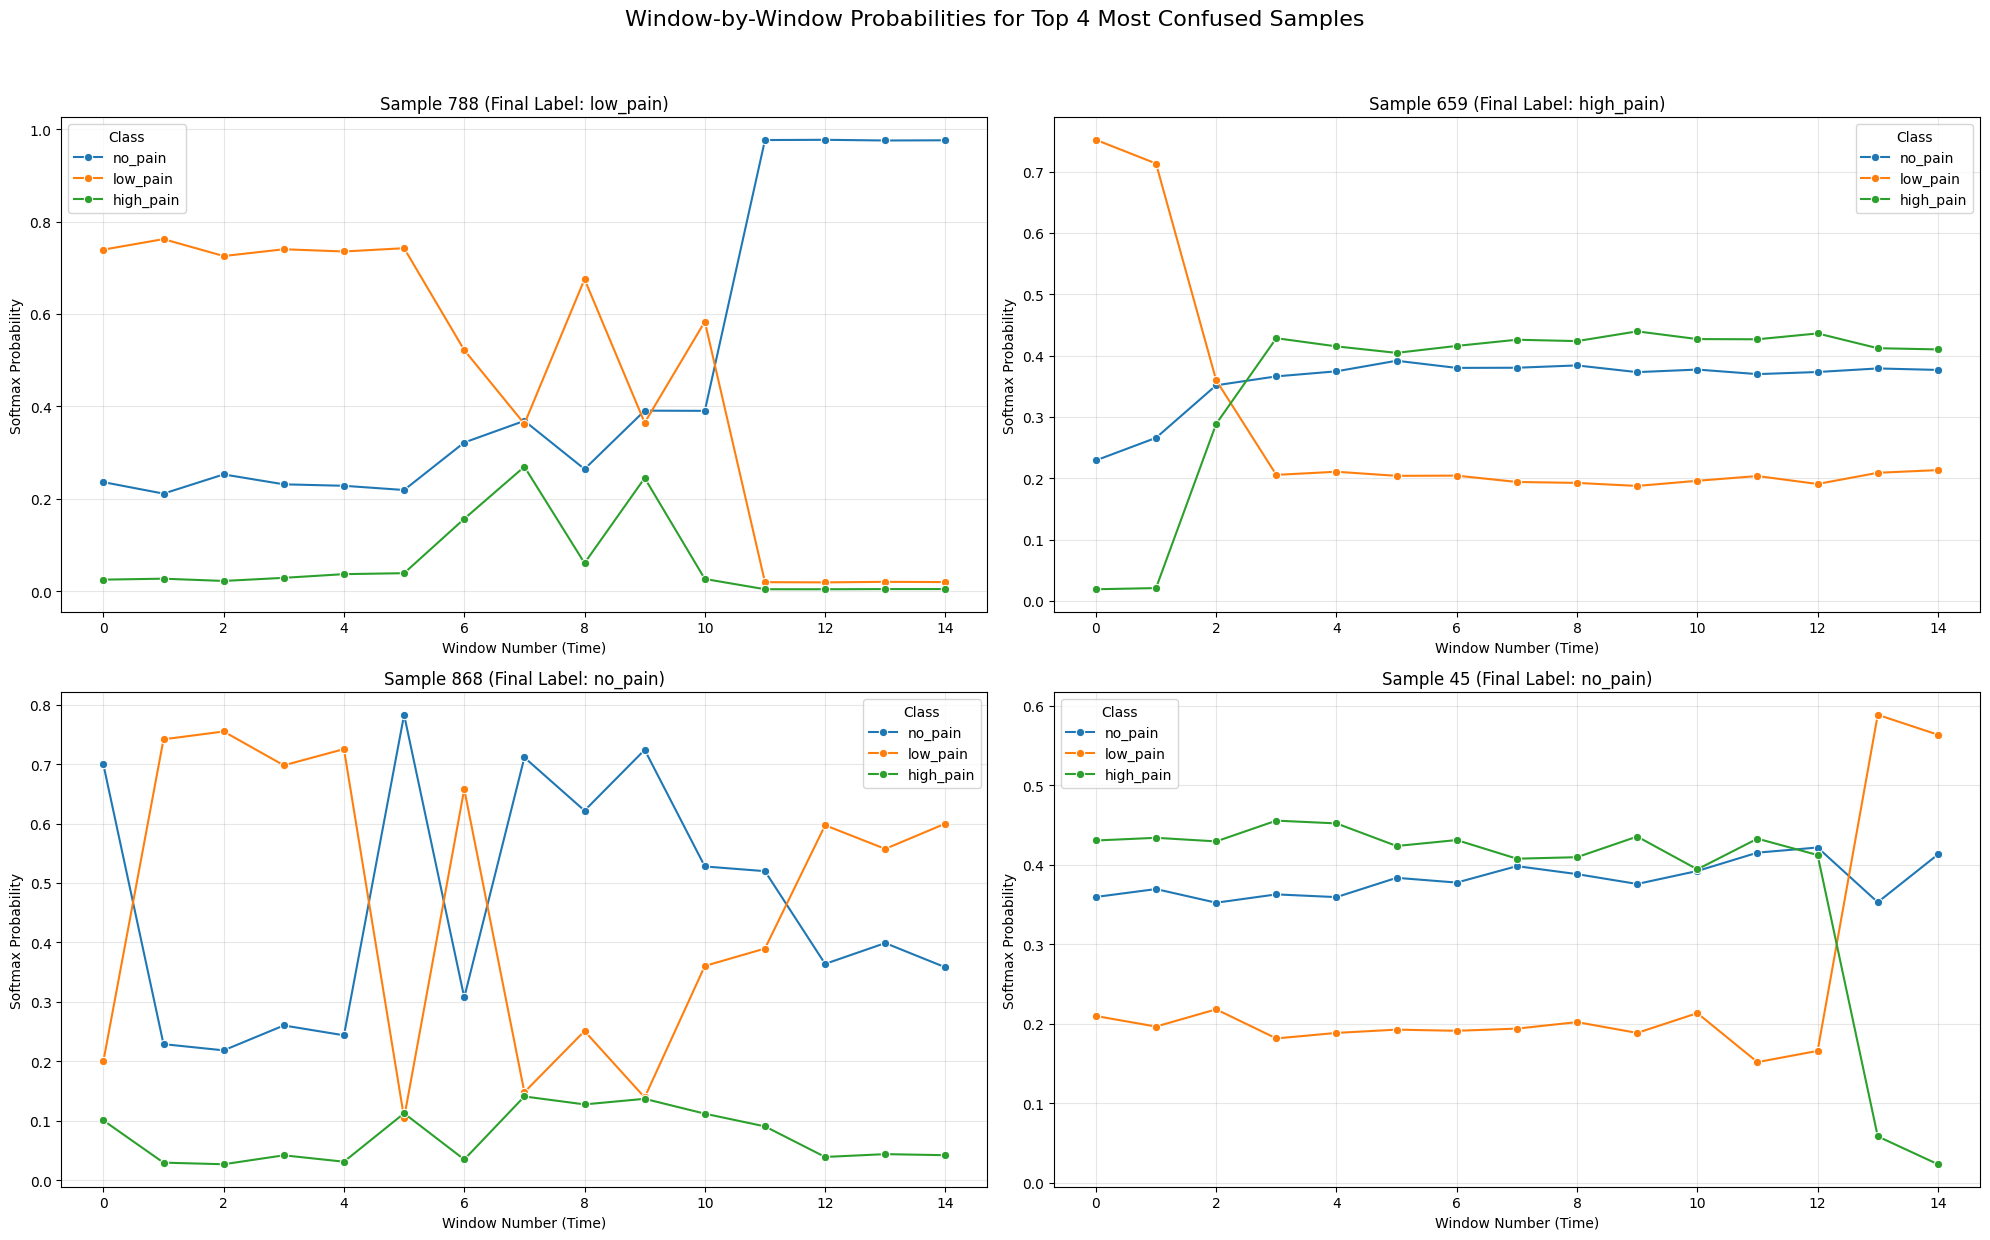

Predictions saved to submissions/submission_final_model_54_epochs_20251113_183543.csv
Probabilities saved to submissions_probs/submission_probs_final_model_54_epochs_20251113_183543_SEED100.txt

--- Final Submission Summary (from submission_df) ---
  sample_index    label
0            0  no_pain
1            1  no_pain
2            2  no_pain
3            3  no_pain
4            4  no_pain


In [294]:

print("\n--- Starting Analysis & Submission ---")

# --- 1. AGGREGATE PREDICTIONS ---
score_cols = [inverse_label_map[i] for i in range(len(label_map))]
df_window_scores = pd.DataFrame(all_window_probs, columns=score_cols)
df_window_scores['sample_index'] = test_window_sids

# --- FIX: Convert sample_index to string *immediately* ---
# This makes all future operations (groupby, merge) consistent
df_window_scores['sample_index'] = df_window_scores['sample_index'].astype(str)

print("\nAggregating window predictions using mean probability...")
mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()
final_predictions = mean_probs_per_sample.idxmax(axis=1)
final_predictions.name = 'label'

# submission_df's 'sample_index' will be a string (from mean_probs_per_sample.index)
submission_df = final_predictions.reset_index()

# --- 2. MERGE TO ENSURE ALL SAMPLES ARE PRESENT ---
all_test_sids_df = pd.DataFrame({'sample_index': df_test['sample_index'].unique()})
# --- FIX: Convert to string to match submission_df ---
all_test_sids_df['sample_index'] = all_test_sids_df['sample_index'].astype(str)

# This merge is now safe (str vs str)
submission_df = all_test_sids_df.merge(submission_df, on='sample_index', how='left')

# --- 3. FILL MISSING VALUES (if any) ---
# --- FIX: Changed 'y_train_final' to 'y_train_full' ---
if 'y_train_full' in globals() and len(y_train_full) > 0:
    majority_class_numeric = pd.Series(y_train_full).mode().iloc[0]
else:
    # Fallback just in case y_train_full wasn't created
    print("Warning: 'y_train_full' not found. Defaulting to 'no_pain' for majority class.")
    majority_class_numeric = 0 
    
majority_class_label = inverse_label_map[majority_class_numeric]
    
num_missing = submission_df['label'].isna().sum()
if num_missing > 0:
    print(f"Filling {num_missing} missing predictions with majority class '{majority_class_label}'")
    submission_df['label'] = submission_df['label'].fillna(majority_class_label)


# =============================================================================
# --- 4. ANALYSIS AND VISUALIZATION BLOCK ---
# =============================================================================
print("\n--- Final Test Set Predictions Summary ---")
print(submission_df['label'].value_counts(normalize=True))
print("\n---")

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=submission_df, order=sorted(label_map.keys()))
plt.title('Final Test Set Prediction Distribution')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

# --- 4b. Plot Final Prediction Confidence (HISTOGRAM) ---
final_confidences = mean_probs_per_sample.max(axis=1)

# --- 4c. Print Most Confused Samples ---
sorted_probs = np.sort(mean_probs_per_sample.values, axis=1)
top_1_probs = sorted_probs[:, -1]
top_2_probs = sorted_probs[:, -2]
mean_probs_per_sample['confidence_margin'] = top_1_probs - top_2_probs

print("\n--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---")
print(mean_probs_per_sample.nsmallest(5, 'confidence_margin')[['confidence_margin'] + score_cols])
print("\n")

# Plot the histogram of these confidences
plt.figure(figsize=(10, 5))
sns.histplot(final_confidences, kde=True, bins=20)
plt.title('Histogram of Final Prediction Confidences')
plt.xlabel('Confidence (Mean Probability of Predicted Class)')
plt.ylabel('Sample Count')
plt.show()

# --- 4d. Plot Window-by-Window Probabilities for Confused Samples ---
most_confused_samples = mean_probs_per_sample.nsmallest(4, 'confidence_margin')
# --- FIX: Index is now string, which is correct ---
most_confused_indices = most_confused_samples.index 

print(f"\n--- Plotting Window-by-Window Probabilities for Top {len(most_confused_indices)} Most Confused Samples ---")

# --- FIX: This type conversion is no longer needed, as both are already strings
# submission_df['sample_index'] = submission_df['sample_index'].astype(type(most_confused_indices[0]))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
for ax, sample_to_plot in zip(axes.flatten(), most_confused_indices):
    
    # --- FIX: This comparison is now str vs str, which is safe ---
    final_label_series = submission_df[submission_df['sample_index'] == sample_to_plot]['label']
    if not final_label_series.empty:
        final_label = final_label_series.values[0]
    else:
        final_label = "Unknown" # Should not happen if merge was correct

    # --- FIX: This comparison is now str vs str, which is safe ---
    df_sample = df_window_scores[df_window_scores['sample_index'] == sample_to_plot]

    df_sample_melted = df_sample.reset_index(drop=True).rename_axis('window_num').reset_index()
    df_sample_melted = df_sample_melted.melt(id_vars=['window_num'], value_vars=score_cols, var_name='class_label', value_name='probability')

    sns.lineplot(data=df_sample_melted, x='window_num', y='probability', hue='class_label', marker='o', ax=ax)
    ax.set_title(f'Sample {sample_to_plot} (Final Label: {final_label})')
    ax.set_xlabel('Window Number (Time)')
    ax.set_ylabel('Softmax Probability')
    ax.legend(title='Class')
    ax.grid(alpha=0.3)

plt.suptitle('Window-by-Window Probabilities for Top 4 Most Confused Samples', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


# =============================================================================
# --- 5. SUBMISSION FILE CREATION ---
# =============================================================================
# This logic is now much simpler because types are consistent

os.makedirs("submissions", exist_ok=True)
os.makedirs("submissions_probs", exist_ok=True)

# 1. Save CSV (Final Labels)
# 'submission_df' is already the final, merged, and filled DataFrame
NAME_CSV_PREDICTION = f"submissions/submission_{experiment_name}.csv"
submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
print(f"Predictions saved to {NAME_CSV_PREDICTION}")

# 2. Prepare Data for TXT (Labels + Probabilities)
# 'mean_probs_per_sample' has a string index
df_txt = mean_probs_per_sample.copy().reset_index() 

# Merge the final label column
df_txt = df_txt.merge(submission_df[['sample_index', 'label']], on='sample_index', how='left')

# Reorder columns
df_txt = df_txt[['sample_index', 'label'] + score_cols]

# 3. Save TXT File
NAME_TXT_PROBS = f"submissions_probs/submission_probs_{experiment_name}_SEED{SEED}.txt"
df_txt.to_csv(NAME_TXT_PROBS, sep='\t', index=False)
print(f"Probabilities saved to {NAME_TXT_PROBS}")

print("\n--- Final Submission Summary (from submission_df) ---")
print(submission_df.head())

## Submission

In [ ]:
# --- 8. Save to CSV and TXT ---
os.makedirs("submissions", exist_ok=True)
os.makedirs("submissions_probs", exist_ok=True)

# 1. Save CSV (Final Labels - Original Request)
NAME_CSV_PREDICTION = f"submissions/submission_{experiment_name}.csv"
submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
print(f"Predictions saved to {NAME_CSV_PREDICTION}")

# 2. Prepare Data for TXT (Labels + Probabilities)
# df_txt uses mean_probs_per_sample (from the analysis cell) which contains the raw probabilities.

# Copy mean probabilities and ensure sample_index is a column
df_txt = mean_probs_per_sample.copy().reset_index()

# Merge the final label column (which is in submission_df)
df_txt['sample_index'] = df_txt['sample_index'].apply(lambda x: f"{int(x):03d}")

# Reorder columns: sample_index, final_label, prob_class1, prob_class2, ...
df_txt = df_txt.merge(submission_df[['sample_index', 'label']], on='sample_index', how='left')

df_txt = df_txt[['sample_index', 'label'] + score_cols]
# 3. Save TXT File (Include SEED in filename for traceability)
# Filename format: submission_probs_final_model_59_epochs_TIMESTAMP_SEED100.txt
NAME_TXT_PROBS = f"submissions_probs/submission_probs_{experiment_name}_SEED{SEED}.txt"

# Save using tab separator, without the index, and with the header
df_txt.to_csv(NAME_TXT_PROBS, sep='\t', index=False)
print(f"Probabilities saved to {NAME_TXT_PROBS}")

print(submission_df.head())